In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.metrics

import tissue.api as tissue

import scanpy as sc
sc.settings.set_figure_params(dpi=80)

import warnings
warnings.filterwarnings('ignore')

from statannot import add_stat_annotation

In [3]:
# user = "david.fischer"
# user = "ina"
user = "mayar.ali"

if user == "david.fischer":
    base_path_gcn = "/Users/david.fischer/phd/seafile/DavidFischer_notforFabian/tissue/grid_searches/basel_zurich/"
    base_path_mi = "/Users/david.fischer/phd/seafile/DavidFischer_notforFabian/tissue/grid_searches/basel_zurich/"
    base_path_reg = "/Users/david.fischer/phd/seafile/DavidFischer_notforFabian/tissue/grid_searches/basel_zurich/"
elif user == "ina":
    base_path_gcn = '../../results/GCN/basel_zurich/'
    base_path_reg = '../../results/REG/basel_zurich/'
    
elif user == "mayar.ali":
    base_path_gcn = "/home/iterm/mayar.ali/phd/projects/tissue/grid_searches/refactor/basel_zurich/"
    base_path_mi = "/home/iterm/mayar.ali/phd/projects/tissue/grid_searches/refactor/basel_zurich/"
    base_path_reg = "/home/iterm/mayar.ali/phd/projects/tissue/grid_searches/refactor/basel_zurich/"


In [4]:
dir_figures="/lustre/groups/ml01/workspace/mayar.ali/tissue/figures/basel_zurich/"

In [5]:
data_key='bz'
group_name='grade'
feature_space='molecular'

### 1. Benchmarking molecular features models

A. Loading trained models

In [6]:
source_path={
    "22050309558_GCNSS_NONE_GRADE_STANDARD_basel_zurich_RADIUS_mt": base_path_gcn,
    "2205040840_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS": base_path_gcn,
    "2205160953_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS": base_path_gcn,
    "2205050930_MI_NONE_GRADE_STANDARD_basel_zurich_RADIUS": base_path_mi,
    "2205050931_REG_GRADE_STANDARD": base_path_reg,


}
gs_ids=[
    "22050309558_GCNSS_NONE_GRADE_STANDARD_basel_zurich_RADIUS_mt",
    "2205040840_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS",
    "2205160953_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS",
    "2205050930_MI_NONE_GRADE_STANDARD_basel_zurich_RADIUS",
    "2205050931_REG_GRADE_STANDARD",
]

In [7]:
container = tissue.fits.GridSearchContainer(
    source_path=source_path,
    gs_ids=gs_ids
)
container.load_gs()

loaded 22050309558_GCNSS_NONE_GRADE_STANDARD_basel_zurich_RADIUS_mt: 108 runs with 6-fold cross validation
loaded 2205040840_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS: 108 runs with 6-fold cross validation
loaded 2205160953_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS: 108 runs with 6-fold cross validation
loaded 2205050930_MI_NONE_GRADE_STANDARD_basel_zurich_RADIUS: 162 runs with 6-fold cross validation
loaded 2205050931_REG_GRADE_STANDARD: 72 runs with 6-fold cross validation


B. Model comparison analysis

selected ['model_class']
means=model_class
GCN      0.598101
GCNSS    0.577603
MI       0.578183
MLP      0.472269
Name: test_grade_custom_categorical_acc, dtype: float64
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MLP_molecular v.s. MI_molecular: t-test independent samples, P_val=4.992e-02 stat=-2.229e+00
MI_molecular v.s. GCN_molecular: t-test independent samples, P_val=6.825e-01 stat=-4.212e-01
MI_molecular v.s. GCNSS_molecular: t-test independent samples, P_val=9.894e-01 stat=1.356e-02


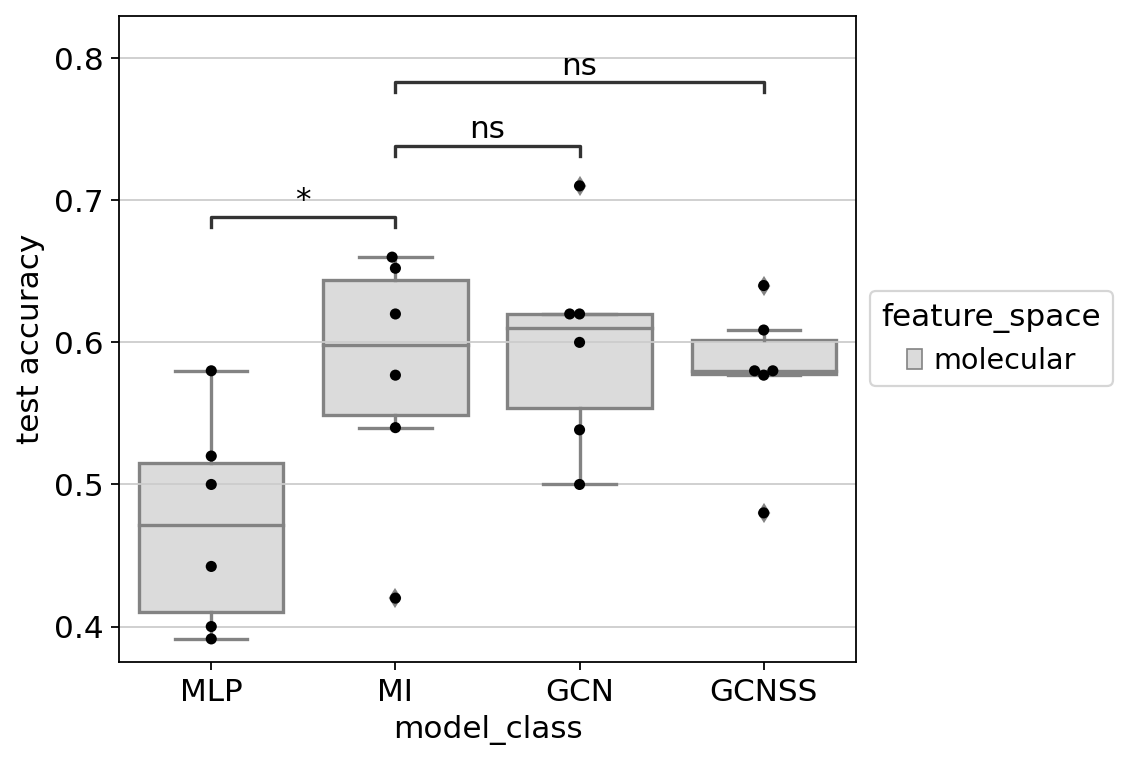

In [12]:
sns.set_palette("gray_r")
container.plot_best_model_by_hyperparam(
    partition_show="test",
    metric_show=group_name + "_custom_categorical_acc",
    partition_select="train",
    metric_select=group_name + "_loss",
    cv_mode="mean",
    param_hue="feature_space", 
    param_x=['model_class'],
#     save=dir_figures+f"model_comaprison_accuracy_{feature_space}", 
    suffix=".pdf",
    panel_width = 7,
    panel_height = 5,
    ttest = True,
)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MLP v.s. MI: t-test independent samples, P_val=1.914e-03 stat=-3.364e+00
MI v.s. GCN: t-test independent samples, P_val=6.354e-01 stat=-4.784e-01
MI v.s. GCNSS: t-test independent samples, P_val=6.950e-01 stat=-3.954e-01


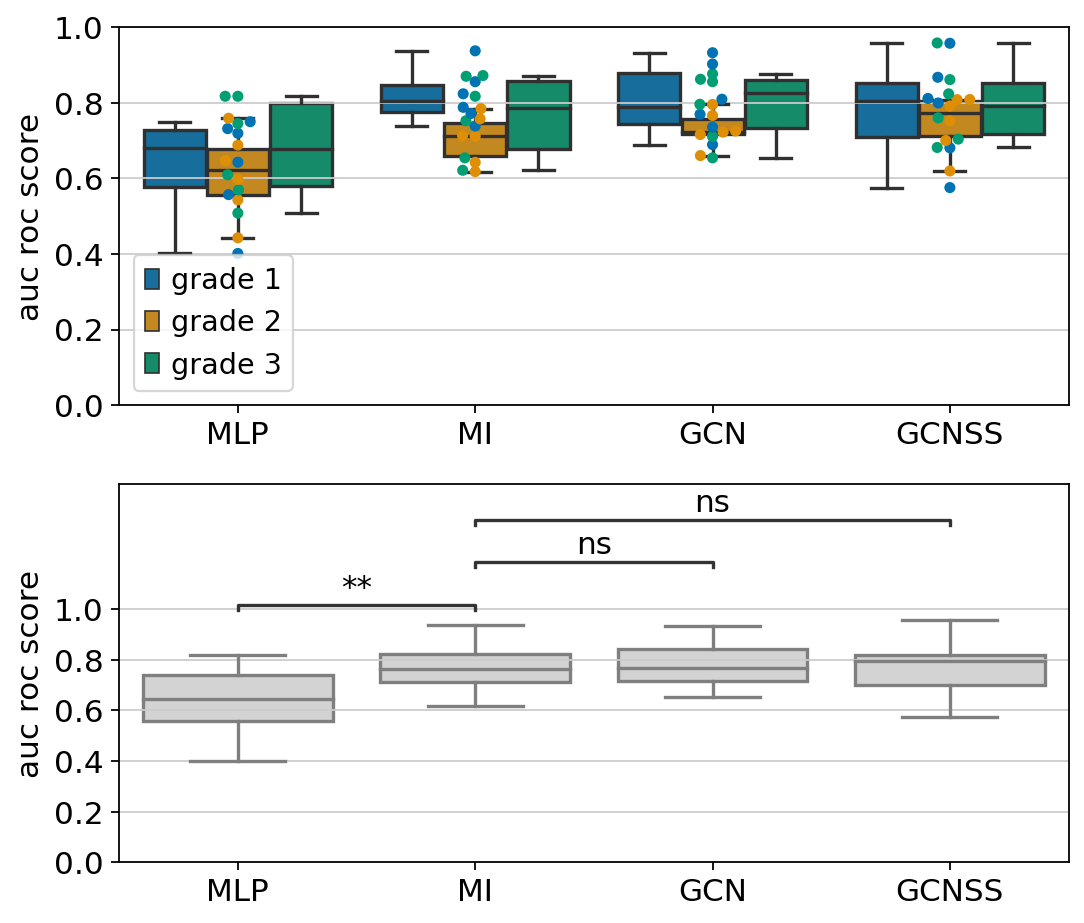

In [8]:
sns.set_palette('colorblind')
container.plot_best_model_roc_auc(
    partition_show="test",
    partition_select="train",
    metric_select=group_name + "_loss",
    cv_mode="mean",
    suffix=".pdf",
    panel_width = 7,
    panel_height = 6,
    plot_all_groups=True,
    ttest=True,
    save=dir_figures+f"model_comparison_roc_auc_{feature_space}_fig2c"
)

C. Comparing best model selection based on train vs validation loss

In [10]:
def preparing_train_val_loss_table(container):
    summary_table_on_val, param, ycol, order, ax = container.plot_best_model_by_hyperparam(
        partition_show="test",
        metric_show=group_name + "_custom_categorical_acc",
        partition_select="val",
        metric_select=group_name + "_loss",
        cv_mode="mean",
        param_hue="feature_space",
        param_x=['model_class'],
        show=False,
        return_summary_table=True
    )


    summary_table_on_train, param, ycol, order, ax = container.plot_best_model_by_hyperparam(
        partition_show="test",
        metric_show=group_name + "_custom_categorical_acc",
        partition_select="train",
        metric_select=group_name + "_loss",
        cv_mode="mean",
        param_hue="feature_space", 
        param_x=['model_class'],
        show=False,
        return_summary_table=True
    )

    summary_table = pd.concat([summary_table_on_train, summary_table_on_val])
    return summary_table, param, ycol, order, ax

selected ['model_class']
selected ['model_class']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MI_train v.s. MI_val: t-test independent samples, P_val=9.719e-01 stat=3.615e-02
MLP_train v.s. MLP_val: t-test independent samples, P_val=1.000e+00 stat=0.000e+00
GCN_train v.s. GCN_val: t-test independent samples, P_val=1.739e-01 stat=1.464e+00
GCNSS_train v.s. GCNSS_val: t-test independent samples, P_val=5.128e-01 stat=-6.786e-01


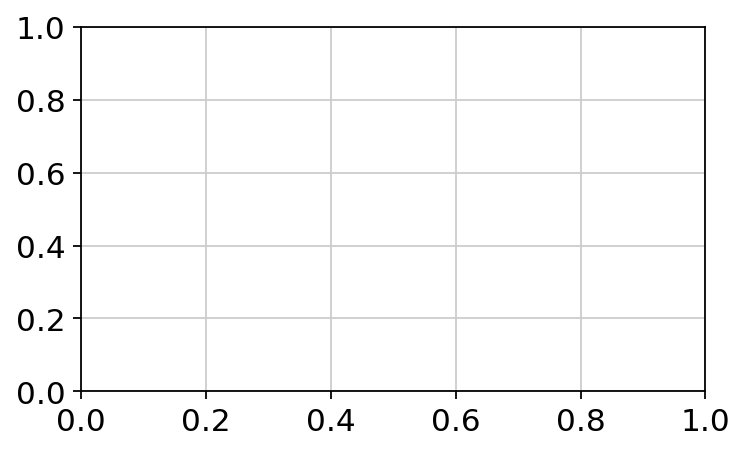

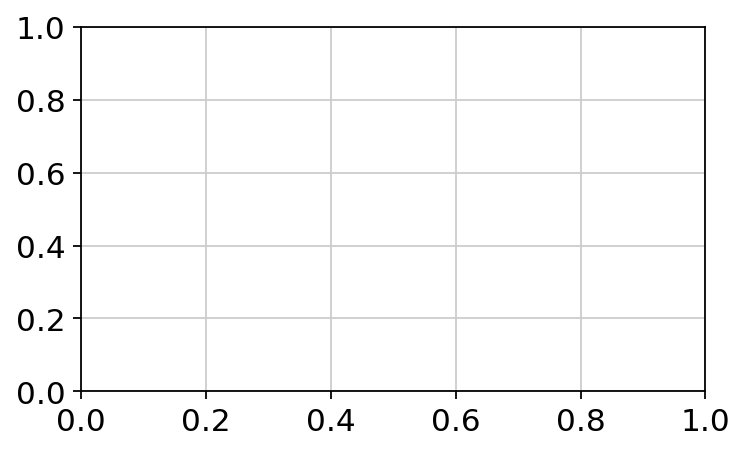

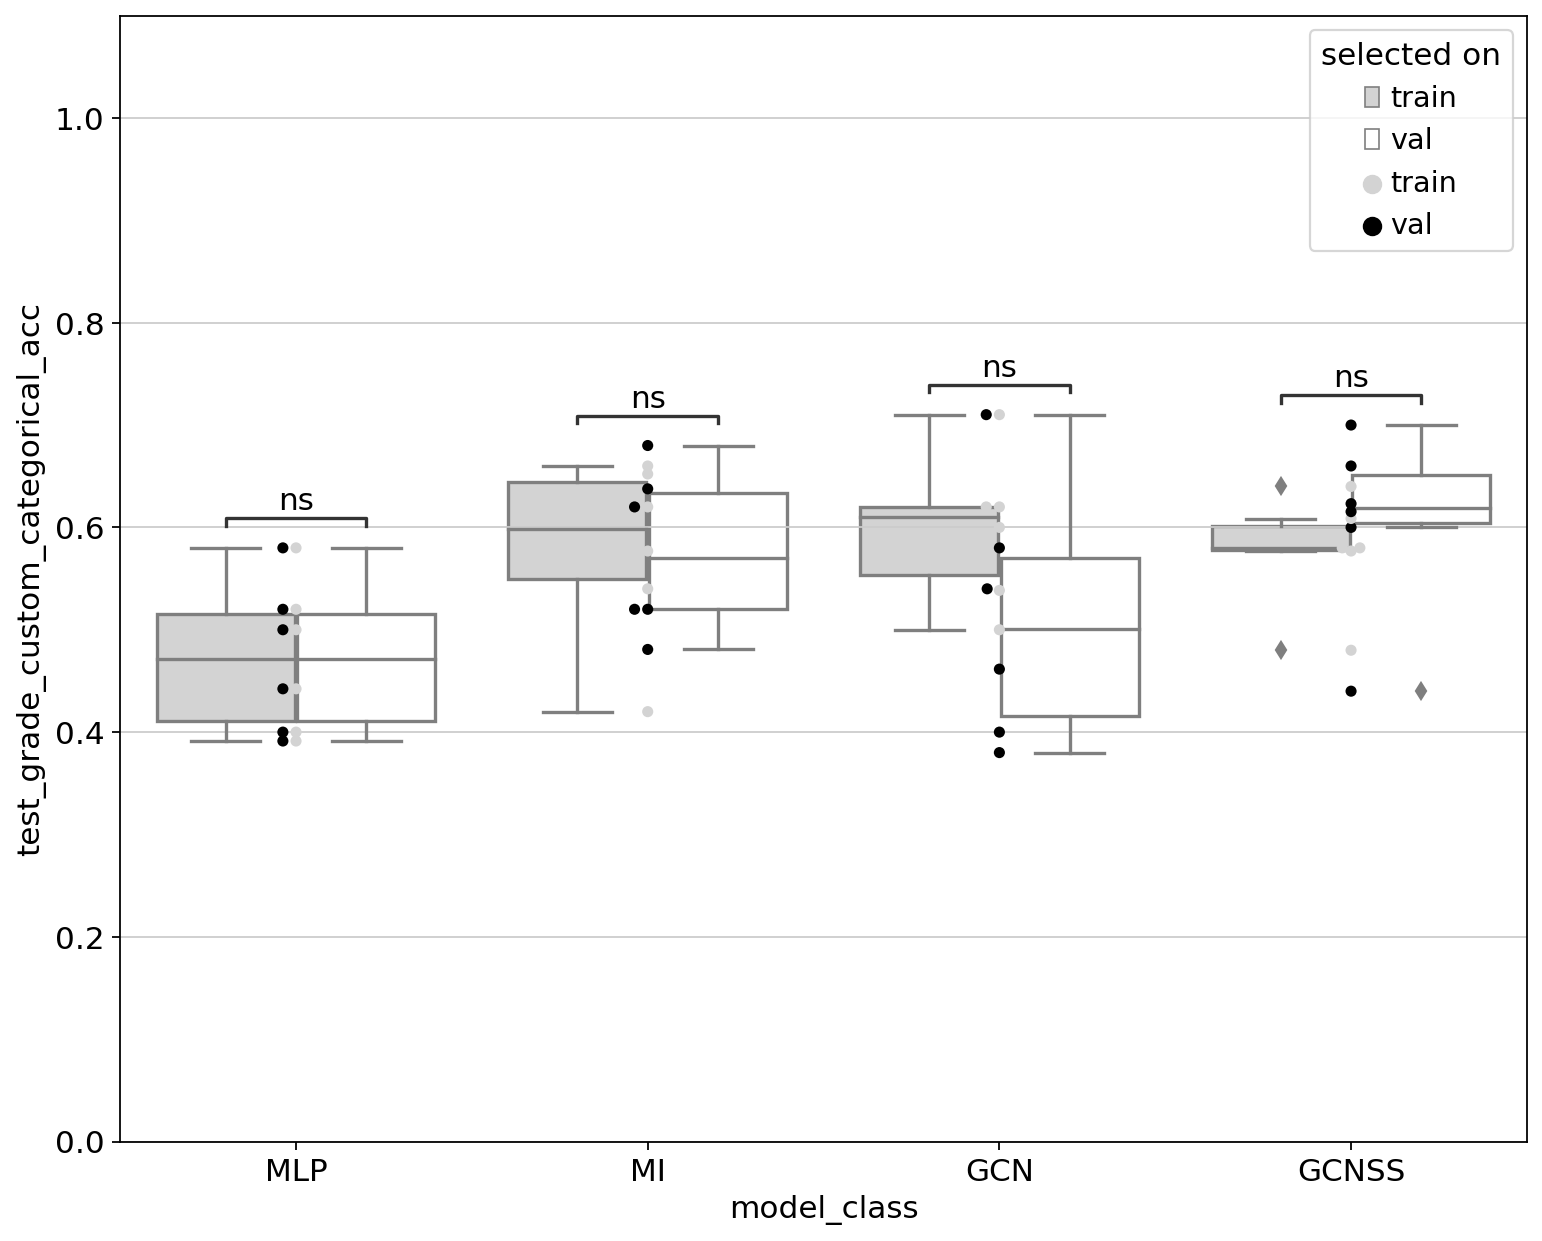

In [11]:
# plotting test accuracy selected on train vs validation loss

summary_table, param, ycol, order, ax = preparing_train_val_loss_table(container)

plt.ioff()
fig, ax = plt.subplots(
    nrows=1, ncols=1,
    figsize=(10, 8),
    sharey='col'
)
summary_table["selected on"] = summary_table["partition_select"]   
bp = sns.boxplot(
                x=param, 
                hue="selected on", 
                y=ycol,
                order=order,
                data=summary_table,
                ax=ax,
                palette=['lightgray', 'w']
    
                )
sns.swarmplot(
                x=param, 
                hue="selected on", 
                y=ycol, 
                order=order,
                data=summary_table,
                ax=ax,
                palette=['lightgray', 'black']
            )

add_stat_annotation(data=summary_table, 
                    x=param, 
                    y=ycol, hue="partition_select",
                    ax=ax, 
                    box_pairs=[(("MLP", "train"), ("MLP", "val")),
                                (("MI", "train"), ("MI", "val")),
                                (("GCN", "train"), ("GCN", "val")),
                                (("GCNSS", "train"), ("GCNSS", "val")),
                                ],
                    order=order,
                    test='t-test_ind', 
                    text_format='star',
                    loc='inside', 
                    verbose=2, 
                    comparisons_correction=None)


plt.tight_layout()
plt.ylim(bottom=0.0, top=1.1)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.savefig(dir_figures + f"model_comparison_selection_partition_{feature_space}_supfig3d_01" + ".pdf")
plt.show()

selected ['model_class']
means=model_class
GCN      0.511947
GCNSS    0.606429
MI       0.576408
MLP      0.472269
Name: test_grade_custom_categorical_acc, dtype: float64
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MLP_molecular v.s. MI_molecular: t-test independent samples, P_val=4.107e-02 stat=-2.344e+00
MI_molecular v.s. GCN_molecular: t-test independent samples, P_val=3.102e-01 stat=1.069e+00
MI_molecular v.s. GCNSS_molecular: t-test independent samples, P_val=5.527e-01 stat=-6.144e-01


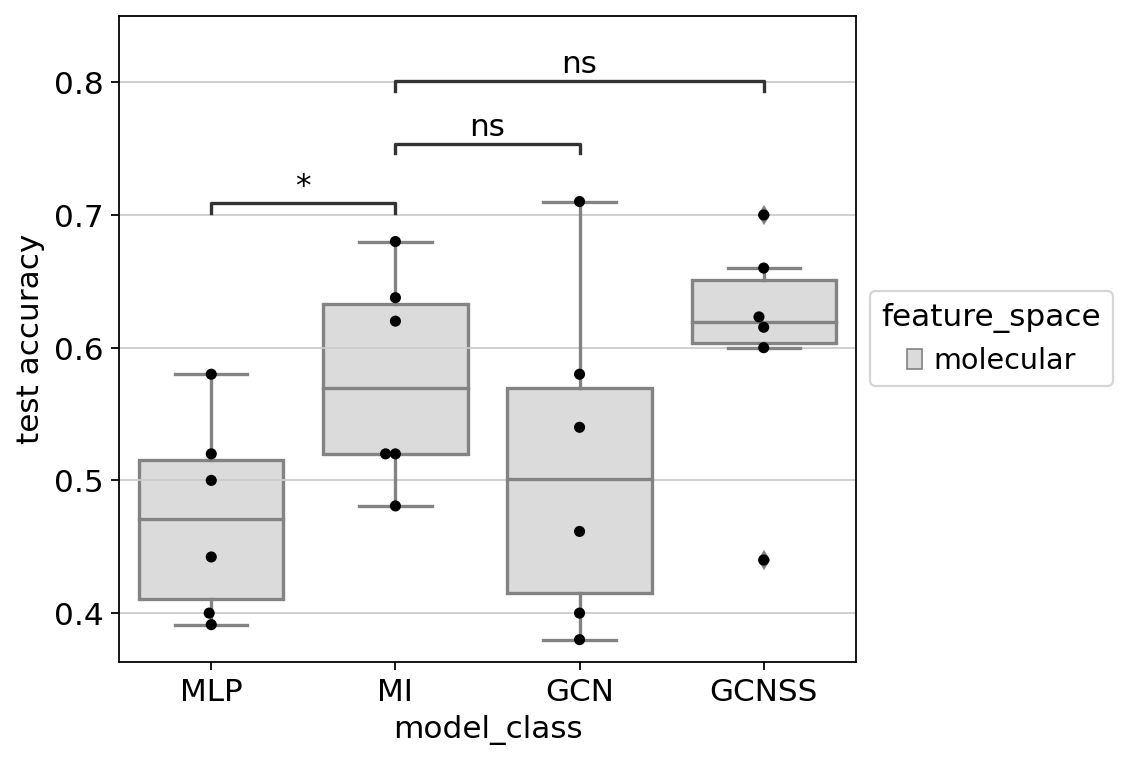

In [40]:
# test accuracy on validation partition selection
sns.set_palette('gray_r')
container.plot_best_model_by_hyperparam(
    partition_show="test",
    metric_show=group_name + "_custom_categorical_acc",
    partition_select="val",
    metric_select=group_name + "_loss",
    cv_mode="mean",
    param_hue="feature_space", 
    param_x=['model_class'],
#     save=dir_figures+f"model_comaprison_accuracy_on_val{feature_space}", 
    suffix=".pdf",
    panel_width = 7,
    panel_height = 5,
    ttest = True,
)

### 2. Multitask settings comparison for molecular features models

A. Loading trained models

In [12]:
source_path={
    # multitask setting
    "22050309558_GCNSS_NONE_GRADE_STANDARD_basel_zurich_RADIUS_mt": base_path_gcn,
    "2205040840_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS": base_path_gcn,
    "2205160953_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS": base_path_gcn,
    "2205050930_MI_NONE_GRADE_STANDARD_basel_zurich_RADIUS": base_path_mi,
    "2205050931_REG_GRADE_STANDARD": base_path_reg,
    
    # target
    "2206111030_GCNSS_NONE_GRADE_STANDARD_basel_zurich_RADIUS_TARGET_mt": base_path_gcn,
    "2206101353_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS_TARGET": base_path_gcn,
    "2206101356_MI_NONE_GRADE_STANDARD_basel_zurich_RADIUS": base_path_mi,
    "2206101356_REG_GRADE_STANDARD_TARGET": base_path_reg,


}
gs_ids=[
    # multitask setting
    "22050309558_GCNSS_NONE_GRADE_STANDARD_basel_zurich_RADIUS_mt",
    "2205040840_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS",
    "2205160953_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS",
    "2205050930_MI_NONE_GRADE_STANDARD_basel_zurich_RADIUS",
    "2205050931_REG_GRADE_STANDARD",
    
    # target
    "2206111030_GCNSS_NONE_GRADE_STANDARD_basel_zurich_RADIUS_TARGET_mt",
    "2206101353_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS_TARGET",
    "2206101356_MI_NONE_GRADE_STANDARD_basel_zurich_RADIUS",
    "2206101356_REG_GRADE_STANDARD_TARGET",
    
]

In [13]:
container_mt = tissue.fits.GridSearchContainer(
    source_path=source_path,
    gs_ids=gs_ids
)
container_mt.load_gs()

loaded 22050309558_GCNSS_NONE_GRADE_STANDARD_basel_zurich_RADIUS_mt: 108 runs with 6-fold cross validation
loaded 2205040840_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS: 108 runs with 6-fold cross validation
loaded 2205160953_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS: 108 runs with 6-fold cross validation
loaded 2205050930_MI_NONE_GRADE_STANDARD_basel_zurich_RADIUS: 162 runs with 6-fold cross validation
loaded 2205050931_REG_GRADE_STANDARD: 72 runs with 6-fold cross validation
File 'gcnss_none_basel_zurich_gradeadam_lr1_dr1_drp1_l21_de2_wi4_lw4_lt1_bs2_md2_tk1_ck1_fsstandard_fe0_fpmean_mttarget_nc2_ew1_nh1_ssmultitask_cv3_evaluation.pickle' missing
File 'gcnss_none_basel_zurich_gradeadam_lr1_dr1_drp1_l21_de2_wi4_lw4_lt1_bs2_md2_tk1_ck1_fsstandard_fe0_fpmean_mttarget_nc2_ew1_nh1_ssmultitask_cv3_history.pickle' missing
File 'gcnss_none_basel_zurich_gradeadam_lr1_dr1_drp1_l21_de2_wi4_lw4_lt1_bs2_md2_tk1_ck1_fsstandard_fe0_fpmean_mttarget_nc2_ew1_nh1_ssmultitask_cv3_hyperparam.pickle' mi

File 'gcnss_none_basel_zurich_gradeadam_lr2_dr1_drp1_l22_de2_wi2_lw1_lt1_bs2_md2_tk1_ck1_fsstandard_fe0_fpmean_mttarget_nc1_ew1_nh1_ssmultitask_cv1_evaluation.pickle' missing
File 'gcnss_none_basel_zurich_gradeadam_lr2_dr1_drp1_l22_de2_wi2_lw1_lt1_bs2_md2_tk1_ck1_fsstandard_fe0_fpmean_mttarget_nc1_ew1_nh1_ssmultitask_cv1_history.pickle' missing
File 'gcnss_none_basel_zurich_gradeadam_lr2_dr1_drp1_l22_de2_wi2_lw1_lt1_bs2_md2_tk1_ck1_fsstandard_fe0_fpmean_mttarget_nc1_ew1_nh1_ssmultitask_cv1_hyperparam.pickle' missing
File 'gcnss_none_basel_zurich_gradeadam_lr2_dr1_drp1_l22_de2_wi2_lw1_lt1_bs2_md2_tk1_ck1_fsstandard_fe0_fpmean_mttarget_nc1_ew1_nh1_ssmultitask_cv1_get_data_args.pickle' missing
File 'gcnss_none_basel_zurich_gradeadam_lr2_dr1_drp1_l22_de2_wi2_lw1_lt1_bs2_md2_tk1_ck1_fsstandard_fe0_fpmean_mttarget_nc1_ew1_nh1_ssmultitask_cv1_model_args.pickle' missing
File 'gcnss_none_basel_zurich_gradeadam_lr2_dr1_drp1_l22_de2_wi2_lw1_lt1_bs2_md2_tk1_ck1_fsstandard_fe0_fpmean_mttarget_nc1_e

loaded 2206101356_REG_GRADE_STANDARD_TARGET: 62 runs with 6-fold cross validation


B. Multitask settings comaprison analysis

In [14]:
def preparing_summary_table(container):
    """
    renaming fields for comaprison
    """
    container.summary_table.index = np.arange(len(container.summary_table))
    test_acc = np.array([])
    indices = container.summary_table[container.summary_table[f"test_{group_name}_custom_categorical_acc"].isnull()].index
    for row in np.arange(len(container.summary_table)):
        if container.summary_table.loc[row]["multitask_setting"] == "target":
            if row in indices:
                test_acc = np.append(test_acc, container.summary_table.loc[row]["test_custom_categorical_acc"])
            else:
                test_acc = np.append(test_acc, container.summary_table.loc[row][f"test_{group_name}_custom_categorical_acc"])
        else:
            test_acc = np.append(test_acc, container.summary_table.loc[row][f"test_{group_name}_custom_categorical_acc"])


    train_loss = np.array([])
    indices = container.summary_table[container.summary_table["train_grade_loss"].isnull()].index
    for row in np.arange(len(container.summary_table)):
        if container.summary_table.loc[row]["multitask_setting"] == "target":
            if row in indices:
                train_loss = np.append(train_loss, container.summary_table.loc[row]["train_loss"])
            else:
                train_loss = np.append(train_loss, container.summary_table.loc[row][f"train_{group_name}_loss"])
        else:
            train_loss = np.append(train_loss, container.summary_table.loc[row][f"train_{group_name}_loss"])
            
    container.summary_table["test_grade_custom_categorical_acc"] = test_acc
    container.summary_table["train_grade_loss"] = train_loss

In [15]:
preparing_summary_table(container=container_mt)

selected ['model_class']
means=model_class
GCN      0.601145
GCNSS    0.582434
MI       0.604401
MLP      0.512810
Name: test_grade_custom_categorical_acc, dtype: float64
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MI_small v.s. MI_target: t-test independent samples, P_val=2.963e-01 stat=-1.102e+00
MLP_small v.s. MLP_target: t-test independent samples, P_val=4.909e-02 stat=-2.239e+00
GCN_small v.s. GCN_target: t-test independent samples, P_val=8.900e-01 stat=-1.419e-01
GCNSS_small v.s. GCNSS_target: t-test independent samples, P_val=8.198e-01 stat=-2.339e-01


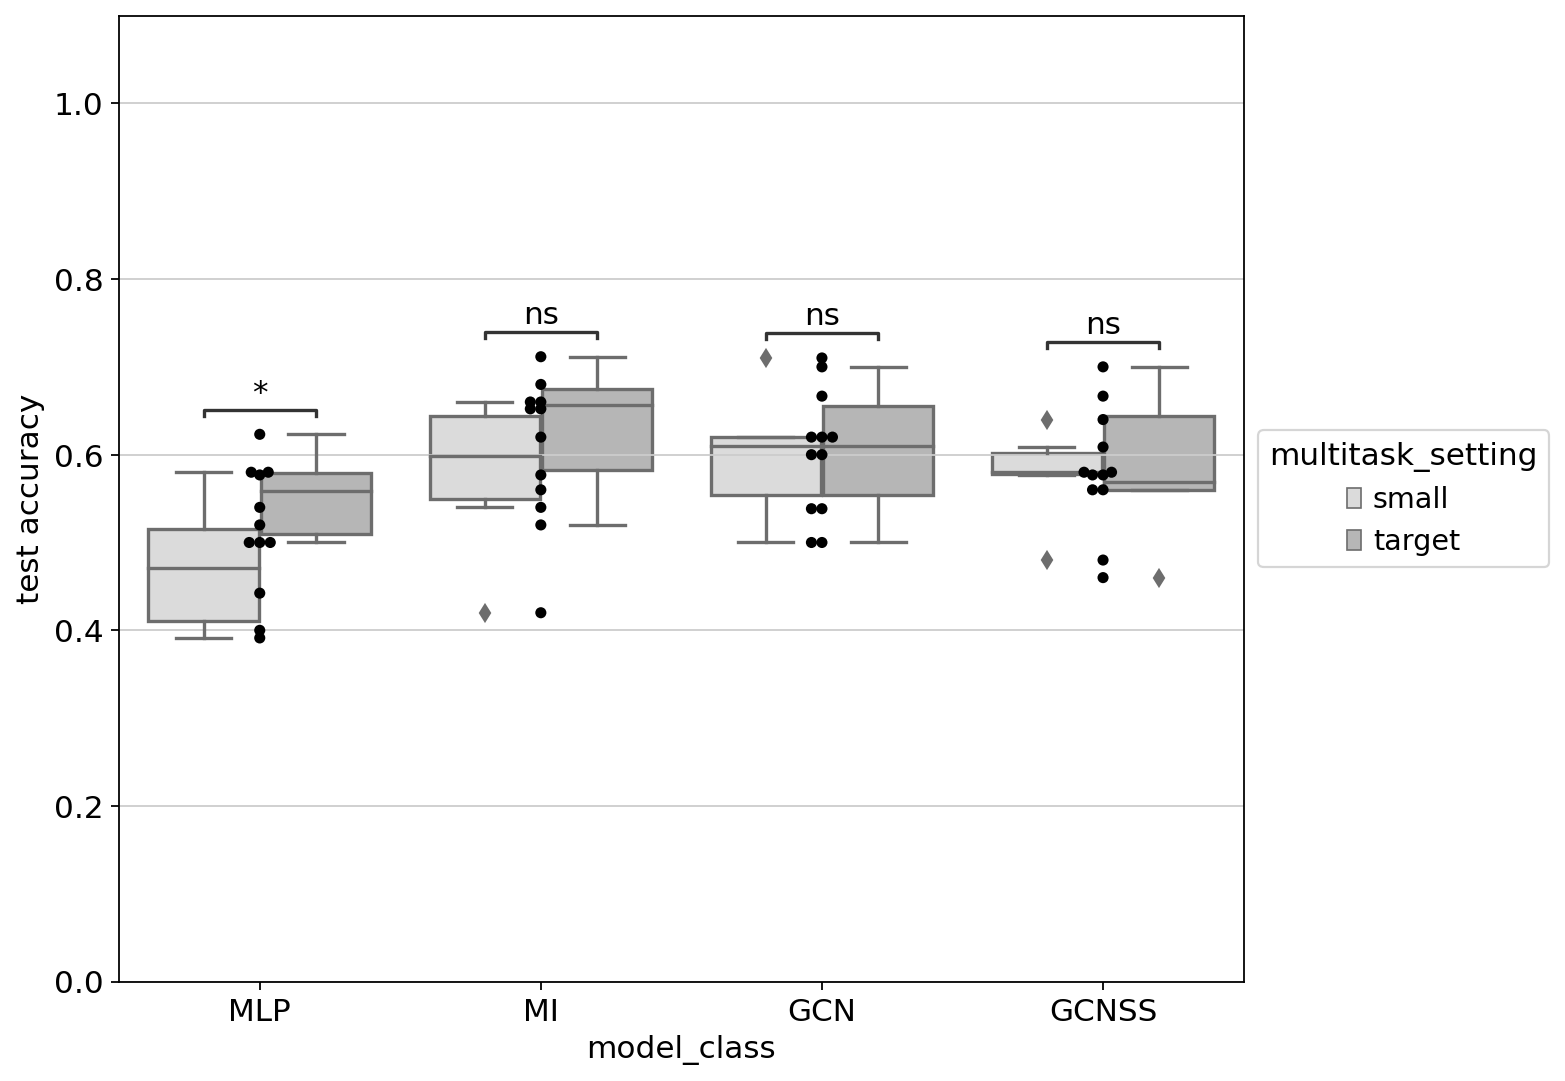

In [17]:
sns.set_palette("gray_r")
container_mt.plot_best_model_by_hyperparam(
    partition_show="test",
    metric_show=group_name + "_custom_categorical_acc",
    partition_select="train",
    metric_select=group_name + "_loss",
    cv_mode="mean",
    param_hue="multitask_setting",  #  feature_space, depth_feature_embedding
    param_x=['model_class'],
    save=dir_figures+f"multitask_setting_comaprison_accuracy_{feature_space}_suppfig6a", 
    suffix=".pdf",
    panel_width = 10,
    panel_height = 7,
    ttest = True,
    multitask=True,
)

### 3. Hyperparameters comparison for molecular features models

A. Loading trained models

In [41]:
container_hyp = tissue.fits.GridSearchContainer(
    source_path=source_path,
    gs_ids=gs_ids,
)
container_hyp.load_gs()

loaded 22050309558_GCNSS_NONE_GRADE_STANDARD_basel_zurich_RADIUS_mt: 108 runs with 6-fold cross validation
loaded 2205040840_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS: 108 runs with 6-fold cross validation
loaded 2205160953_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS: 108 runs with 6-fold cross validation
loaded 2205050930_MI_NONE_GRADE_STANDARD_basel_zurich_RADIUS: 162 runs with 6-fold cross validation
loaded 2205050931_REG_GRADE_STANDARD: 72 runs with 6-fold cross validation


B. Hyperparameter comparison analysis

selected ['model_class']
subset was empty, available values for depth are ['1', '2'], given was 3
subset was empty, available values for depth are ['1'], given was 2
subset was empty, available values for depth are ['1'], given was 3
subset was empty, available values for depth are ['1'], given was 2
subset was empty, available values for depth are ['1'], given was 3
means=model_class
GCN      0.601660
GCNSS    0.577603
MI       0.578183
MLP      0.463681
Name: test_grade_custom_categorical_acc, dtype: float64


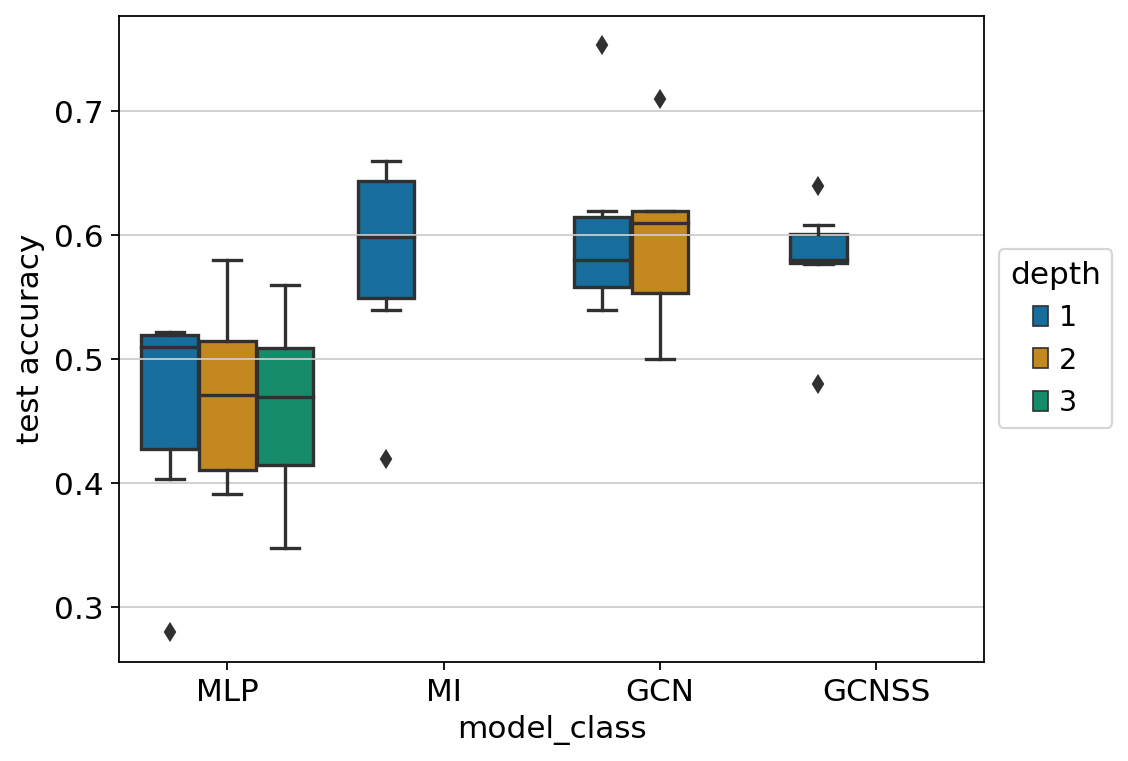

selected ['model_class']
subset was empty, available values for width are ['16', '64'], given was 32
subset was empty, available values for width are ['16', '64'], given was 8
subset was empty, available values for width are ['16', '64'], given was 32
subset was empty, available values for width are ['16', '64'], given was 8
subset was empty, available values for width are ['16', '64', '8'], given was 32
subset was empty, available values for width are ['16', '32'], given was 64
subset was empty, available values for width are ['16', '32'], given was 8
means=model_class
GCN      0.599670
GCNSS    0.605993
MI       0.589993
MLP      0.445676
Name: test_grade_custom_categorical_acc, dtype: float64


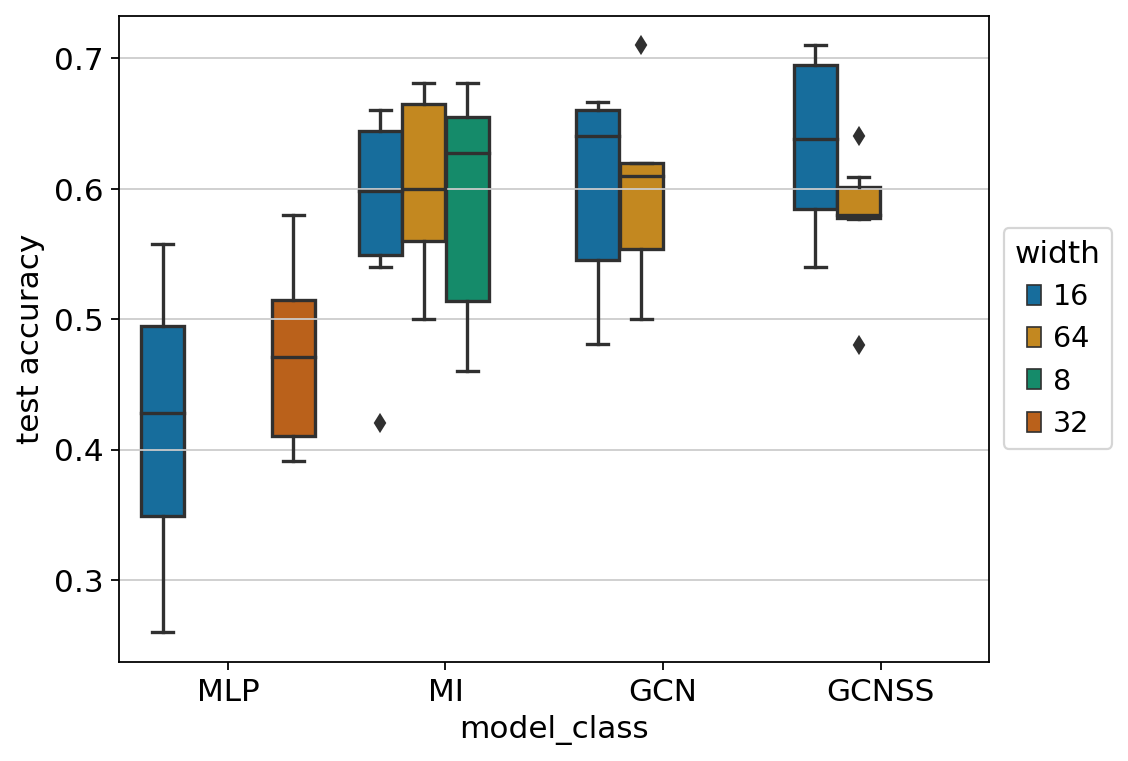

selected ['model_class']
subset was empty, available values for lr are ['0.0005', '0.005'], given was 0.05
means=model_class
GCN      0.590769
GCNSS    0.598945
MI       0.589692
MLP      0.447664
Name: test_grade_custom_categorical_acc, dtype: float64


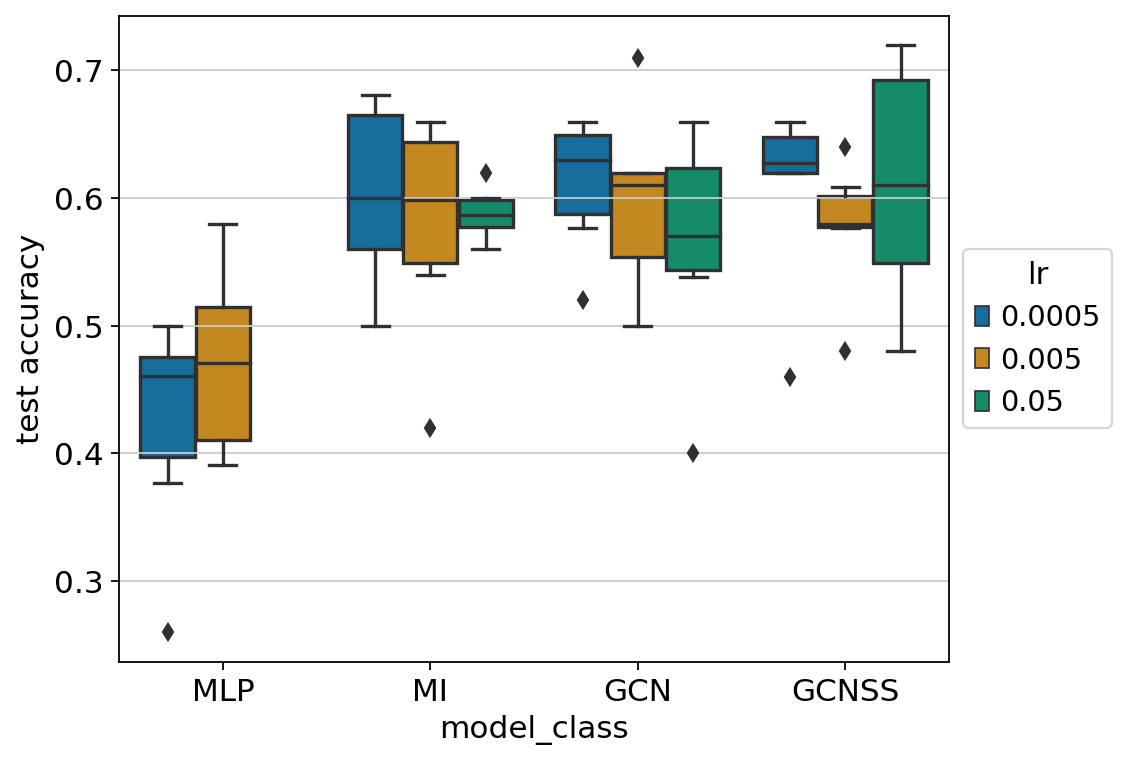

selected ['model_class']
subset was empty, available values for l2 are ['0.0', '0.001', '1e-06'], given was 1.0
subset was empty, available values for l2 are ['0.0', '0.001', '1e-06'], given was 1.0
subset was empty, available values for l2 are ['0.0', '0.001', '1e-06'], given was 1.0
subset was empty, available values for l2 are ['0.0', '0.001', '1.0'], given was 1e-06
means=model_class
GCN      0.611848
GCNSS    0.589224
MI       0.581338
MLP      0.451018
Name: test_grade_custom_categorical_acc, dtype: float64


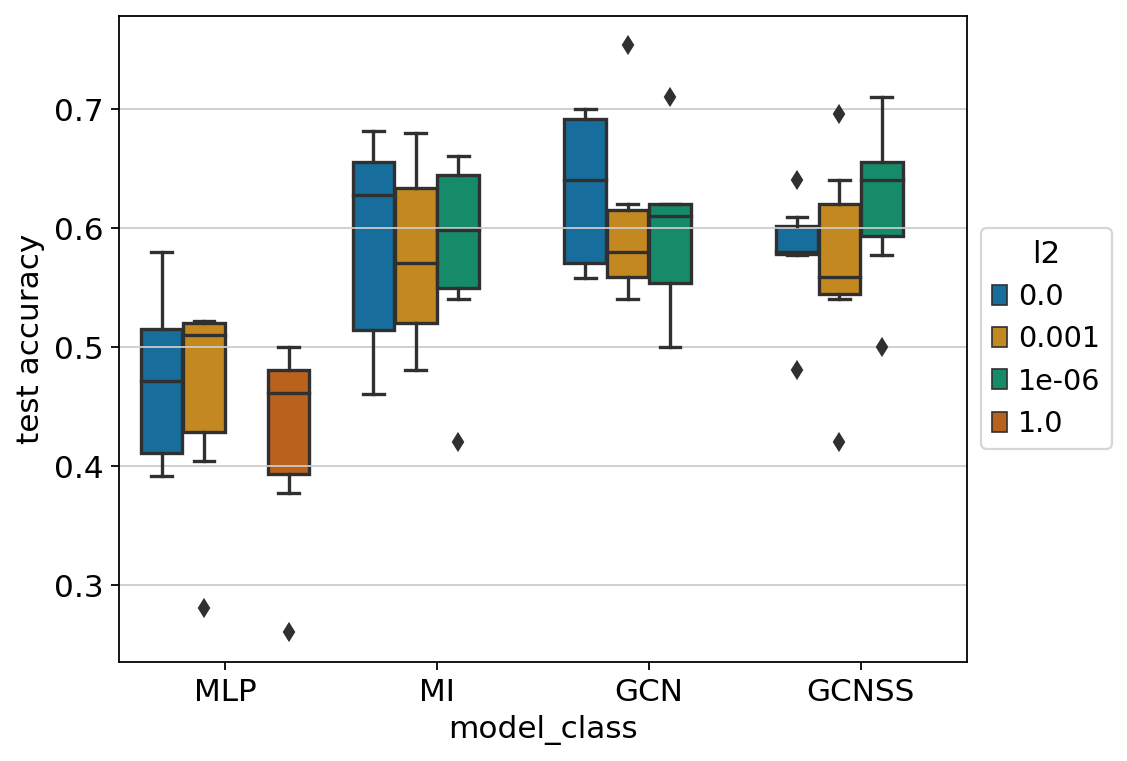

In [45]:
sns.set_palette('colorblind')



# depth
container.plot_best_model_by_hyperparam(
    partition_show="test",
    metric_show=group_name + "_custom_categorical_acc",
    partition_select="train",
    metric_select=group_name + "_loss",
    cv_mode="mean",
    param_hue="depth",  
    param_x=['model_class'],
    suffix=".pdf",
    panel_width = 7,
    panel_height = 5,
    show_swarm = False,
#     save=dir_figures+f"hyperparams_comaprison_accuracy_depth_{feature_space}_suppfig7a", 
)


# width
container.plot_best_model_by_hyperparam(
    partition_show="test",
    metric_show=group_name + "_custom_categorical_acc",
    partition_select="train",
    metric_select=group_name + "_loss",
    cv_mode="mean",
    param_hue="width", 
    param_x=['model_class'],
    suffix=".pdf",
    panel_width = 7,
    panel_height = 5,
    show_swarm = False,
#     save=dir_figures+f"hyperparams_comaprison_accuracy_width_{feature_space}_suppfig7b", 
)


# learning rate
container.plot_best_model_by_hyperparam(
    partition_show="test",
    metric_show=group_name + "_custom_categorical_acc",
    partition_select="train",
    metric_select=group_name + "_loss",
    cv_mode="mean",
    param_hue="lr",  
    param_x=['model_class'],
    suffix=".pdf",
    panel_width = 7,
    panel_height = 5,
    show_swarm = False,
#     save=dir_figures+f"hyperparams_comaprison_accuracy_lr_{feature_space}_suppfig7c", 
)


# L2
container.plot_best_model_by_hyperparam(
    partition_show="test",
    metric_show=group_name + "_custom_categorical_acc",
    partition_select="train",
    metric_select=group_name + "_loss",
    cv_mode="mean",
    param_hue="l2", 
    param_x=['model_class'],
    suffix=".pdf",
    panel_width = 7,
    panel_height = 5,
    show_swarm = False,
#     save=dir_figures+f"hyperparams_comaprison_accuracy_l2_{feature_space}_suppfig7d", 
)

### 4.  Analysis on GCN SS

In [7]:
model_class="GCNSS"

A. Loading trained models

In [8]:
container_gcnss = tissue.fits.GridSearchContainer(
    source_path={
        "22050309558_GCNSS_NONE_GRADE_STANDARD_basel_zurich_RADIUS_mt": base_path_gcn,
    },
    gs_ids=[
        "22050309558_GCNSS_NONE_GRADE_STANDARD_basel_zurich_RADIUS_mt",
    ]
)
container_gcnss.load_gs()

loaded 22050309558_GCNSS_NONE_GRADE_STANDARD_basel_zurich_RADIUS_mt: 108 runs with 6-fold cross validation


In [9]:
gs_id, model_id, cv = container_gcnss.get_best_model_id(partition_select='train')
container_gcnss.get_info(gs_id = gs_id, model_id=model_id)

B. GCN SS analysis

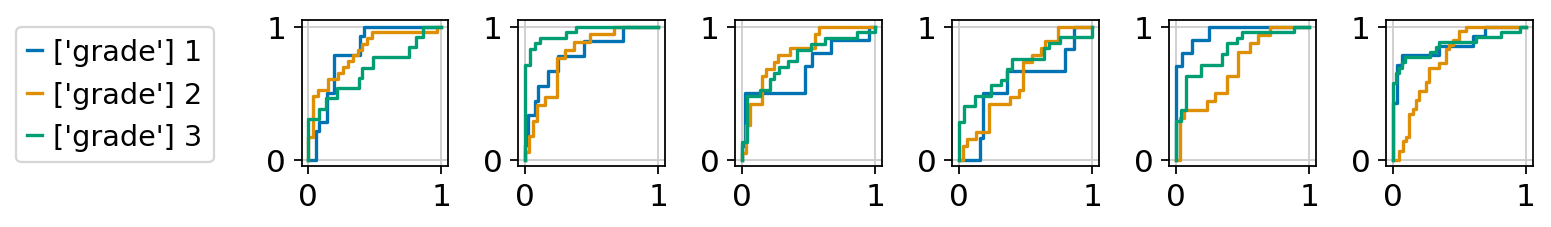

In [48]:
# plotting roc curve for 6-fold cv
sns.set_palette("colorblind")
container_gcnss.plot_roc(partition='test', 
#                          save=dir_figures+f"gcnss_roc_curve_{feature_space}_suppfig3a.pdf"
                        )

Confusion matrix on test set:


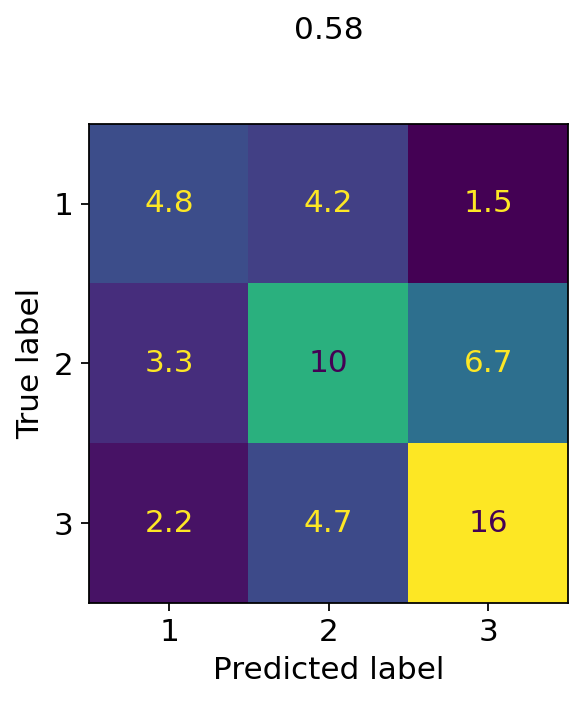

Confusion matrix on val set:


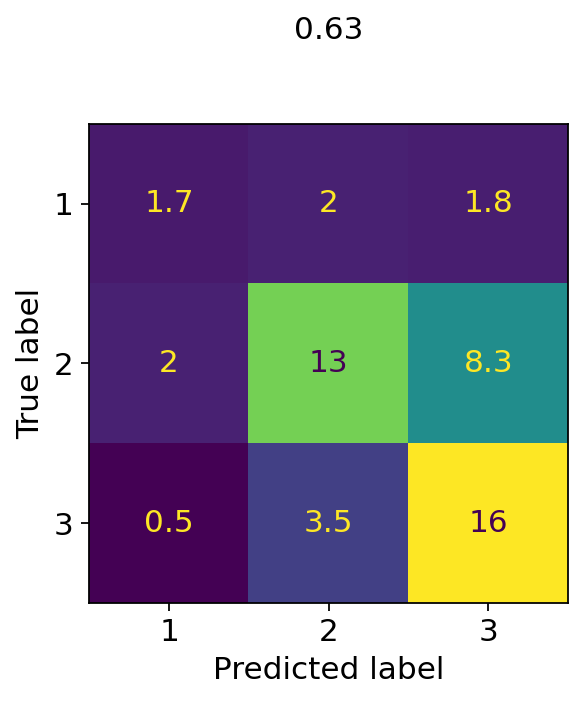

Confusion matrix on train set:


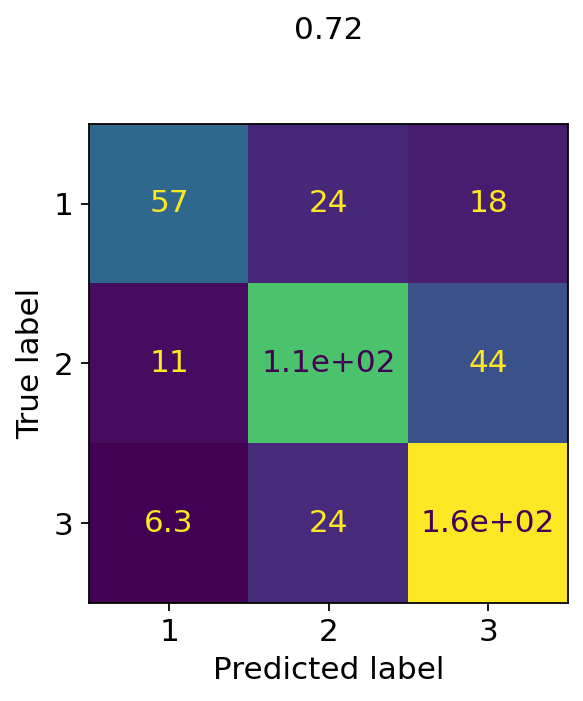


test
Grade 1 : 0.41984126984126985
Grade 2 : 0.5067957507314454
Grade 3 : 0.6755044593088071
mean : 0.577603121516165

val
Grade 1 : 0.34027777777777785
Grade 2 : 0.5601247621803133
Grade 3 : 0.7917357496304863
mean : 0.6329317338988326

train
Grade 1 : 0.5813440624152938
Grade 2 : 0.675652426607253
Grade 3 : 0.8379558748859344
mean : 0.7213178136566545


In [49]:
# plotting confusion metrices
sns.set_palette('colorblind')
print('Confusion matrix on test set:')

container_gcnss.plot_confusion_matrix(
    target_label='grade',
    partition_show='test',
    mean_across_cv=True,
#     save=dir_figures+f"gcnss_analysis_confusion_mtx_test_{feature_space}", 
    x_ticks=['1', '2', '3'],
)

print('Confusion matrix on val set:')

container_gcnss.plot_confusion_matrix(
    target_label='grade',
    partition_show='val',
    mean_across_cv=True,
#     save=dir_figures+f"gcnss_analysis_confusion_mtx_val_{feature_space}", 
    x_ticks=['1', '2', '3'],
)

print('Confusion matrix on train set:')
container_gcnss.plot_confusion_matrix(
    target_label='grade',
    partition_show='train',
    mean_across_cv=True,
#     save=dir_figures+f"gcnss_analysis_confusion_mtx_train_{feature_space}", 
    x_ticks=['1', '2', '3']
)



for partition in ['test', 'val','train']:
    print()
    print(partition)
    mean = []
    for grade in [0, 1, 2]:
        acc = []
        for cv in ['cv0', 'cv1', 'cv2', 'cv3', 'cv4', 'cv5']:
            preds = np.argmax(container_gcnss.info[cv]['predictions'][partition][group_name], axis=1)
            true = np.argmax(container_gcnss.true_labels[cv][partition][group_name], axis=1)
            acc.append(np.mean(preds[true==grade] == true[true==grade]))
            if grade == 0:
                mean.append(np.mean(preds == true))
        mean_acc = np.mean(acc)
        print("Grade", grade+1, ":", mean_acc)
    mean = np.mean(mean)
    print("mean :", mean)

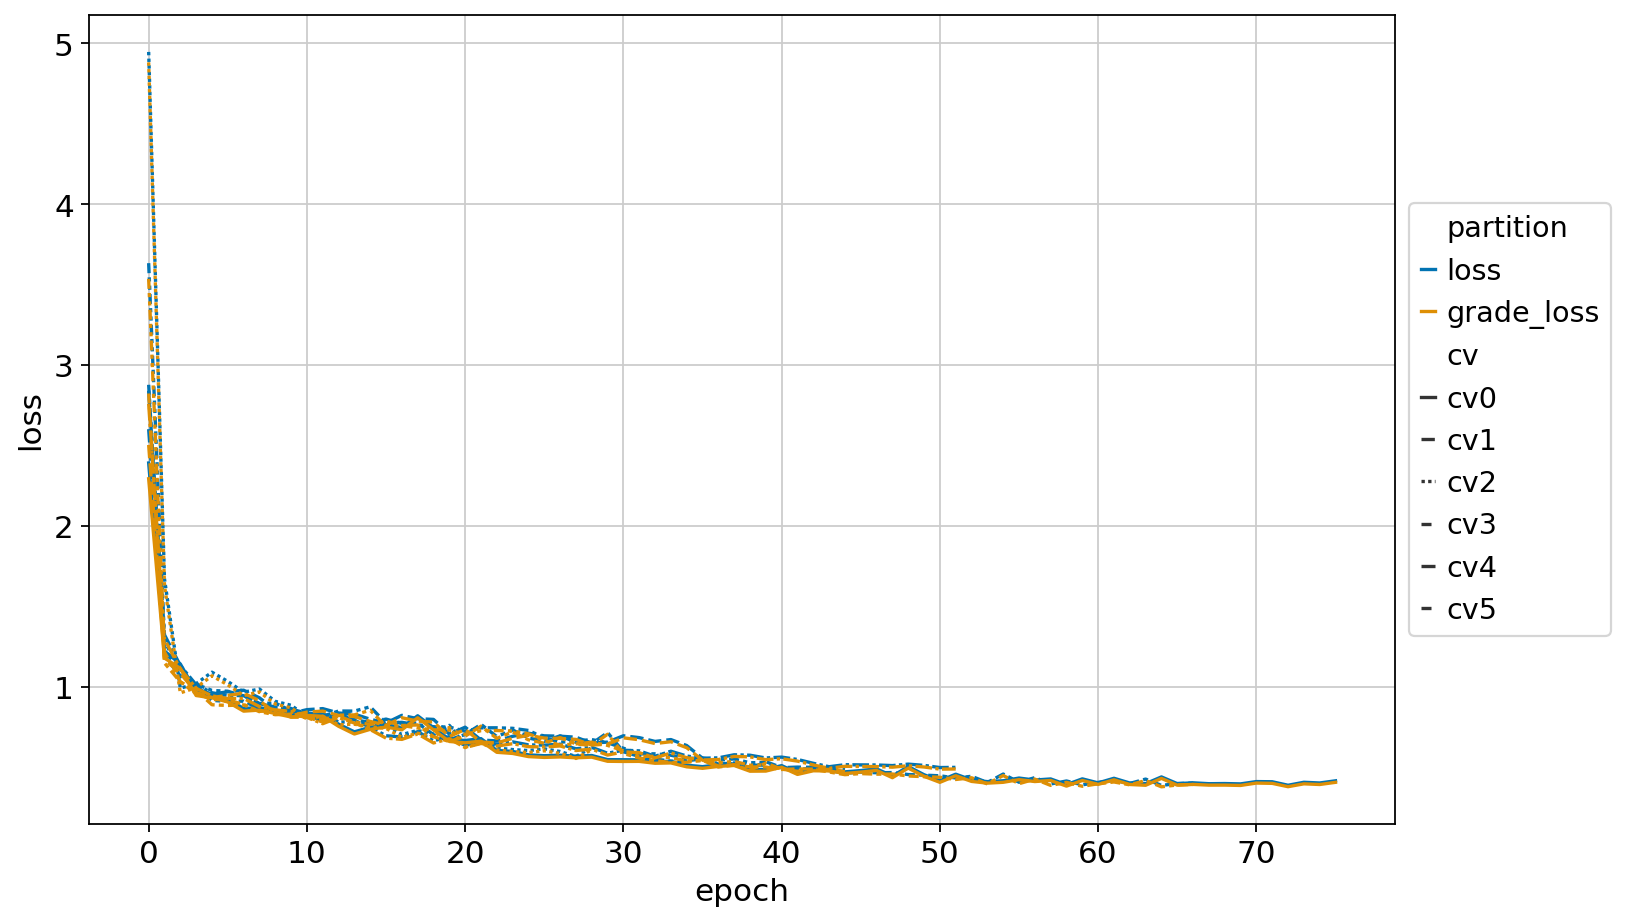

In [50]:
# plotting training history curve
container_gcnss.plot_training_history(
    plot_metrics=['loss', f'{group_name}_loss'],
#     save=dir_figures+f"gcnss_analysis_training_history_curve_{feature_space}_suppfig5b", 
)

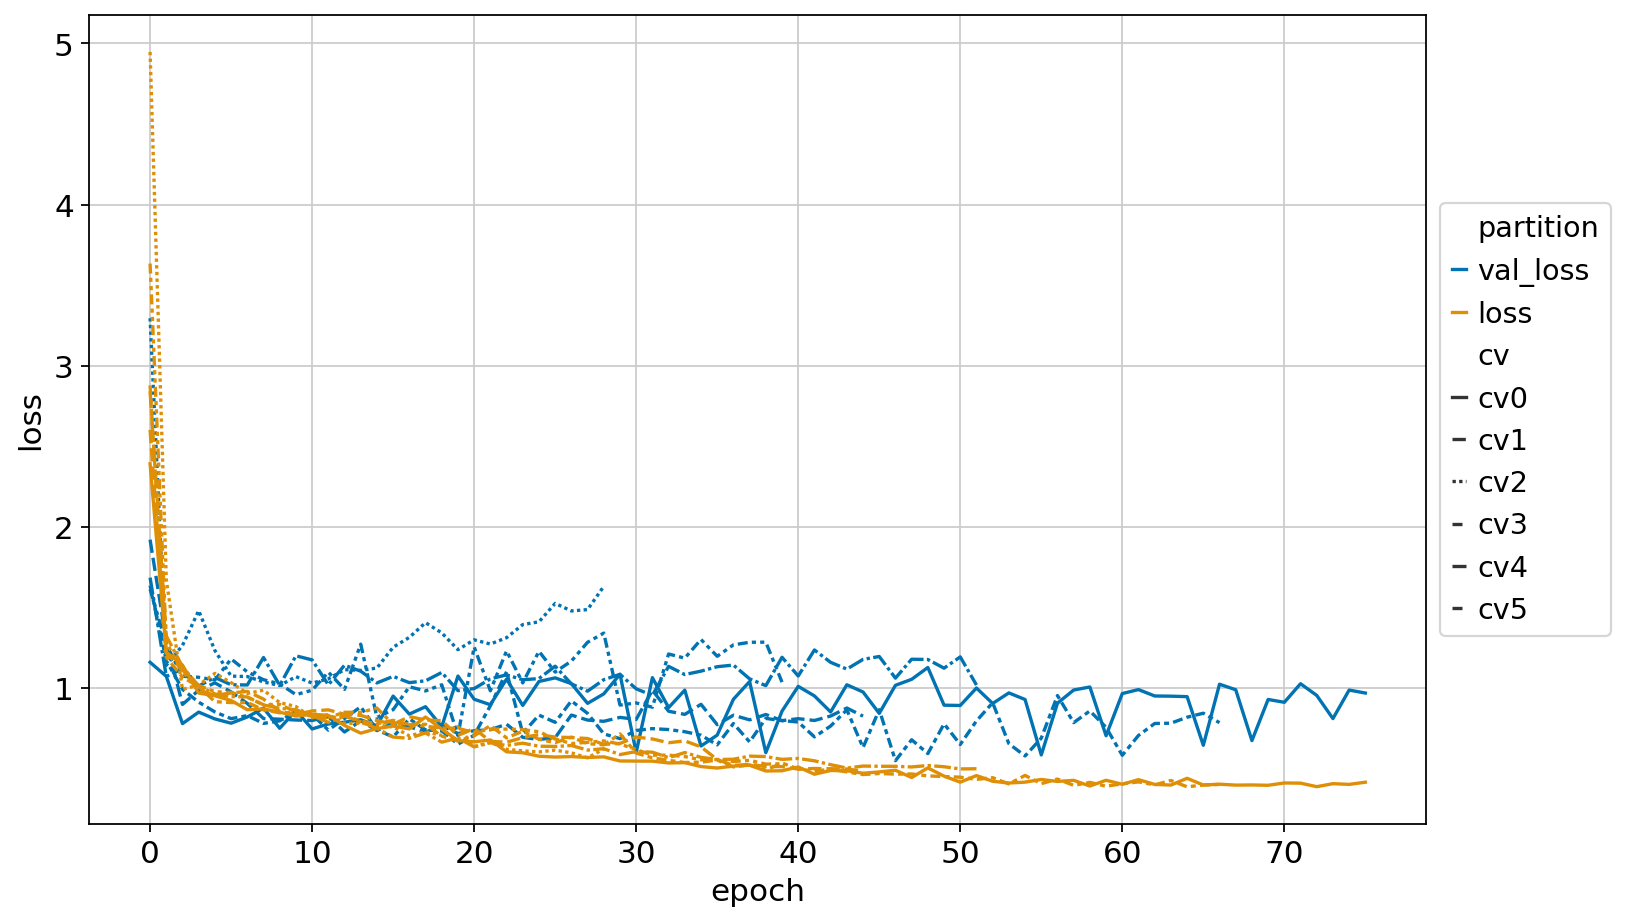

In [51]:
# plotting validation history curve
container_gcnss.plot_training_history(
    plot_metrics=['val_loss', 
                  'loss'],
#     save=dir_figures+f"gcnss_analysis_validation_history_curve_{feature_space}_suppfig6a", 
)

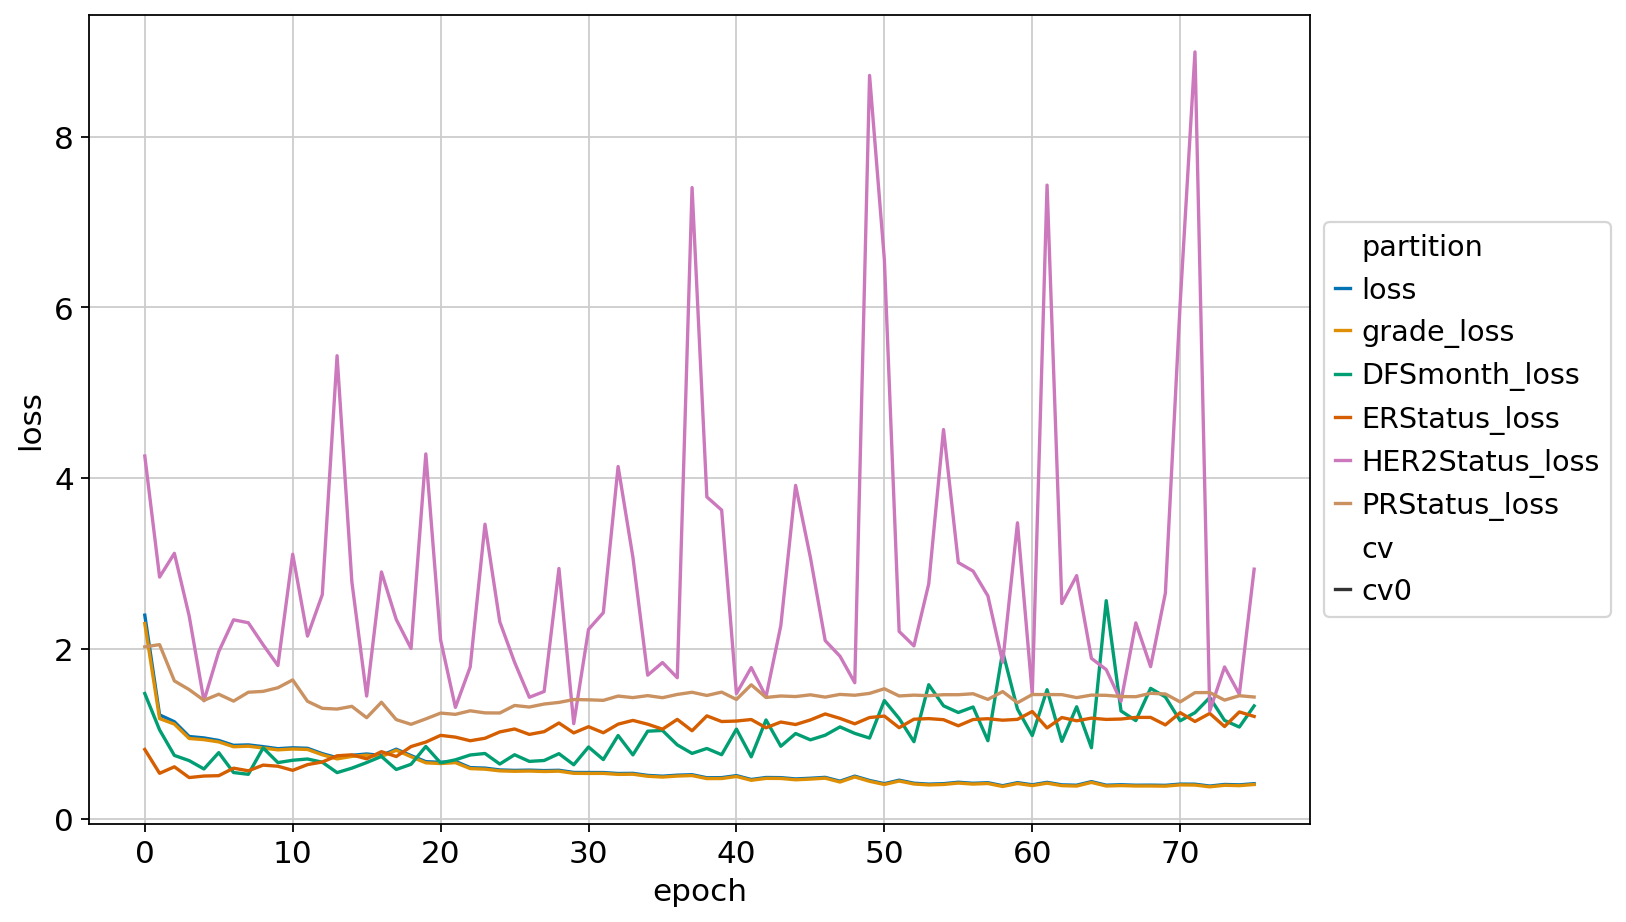

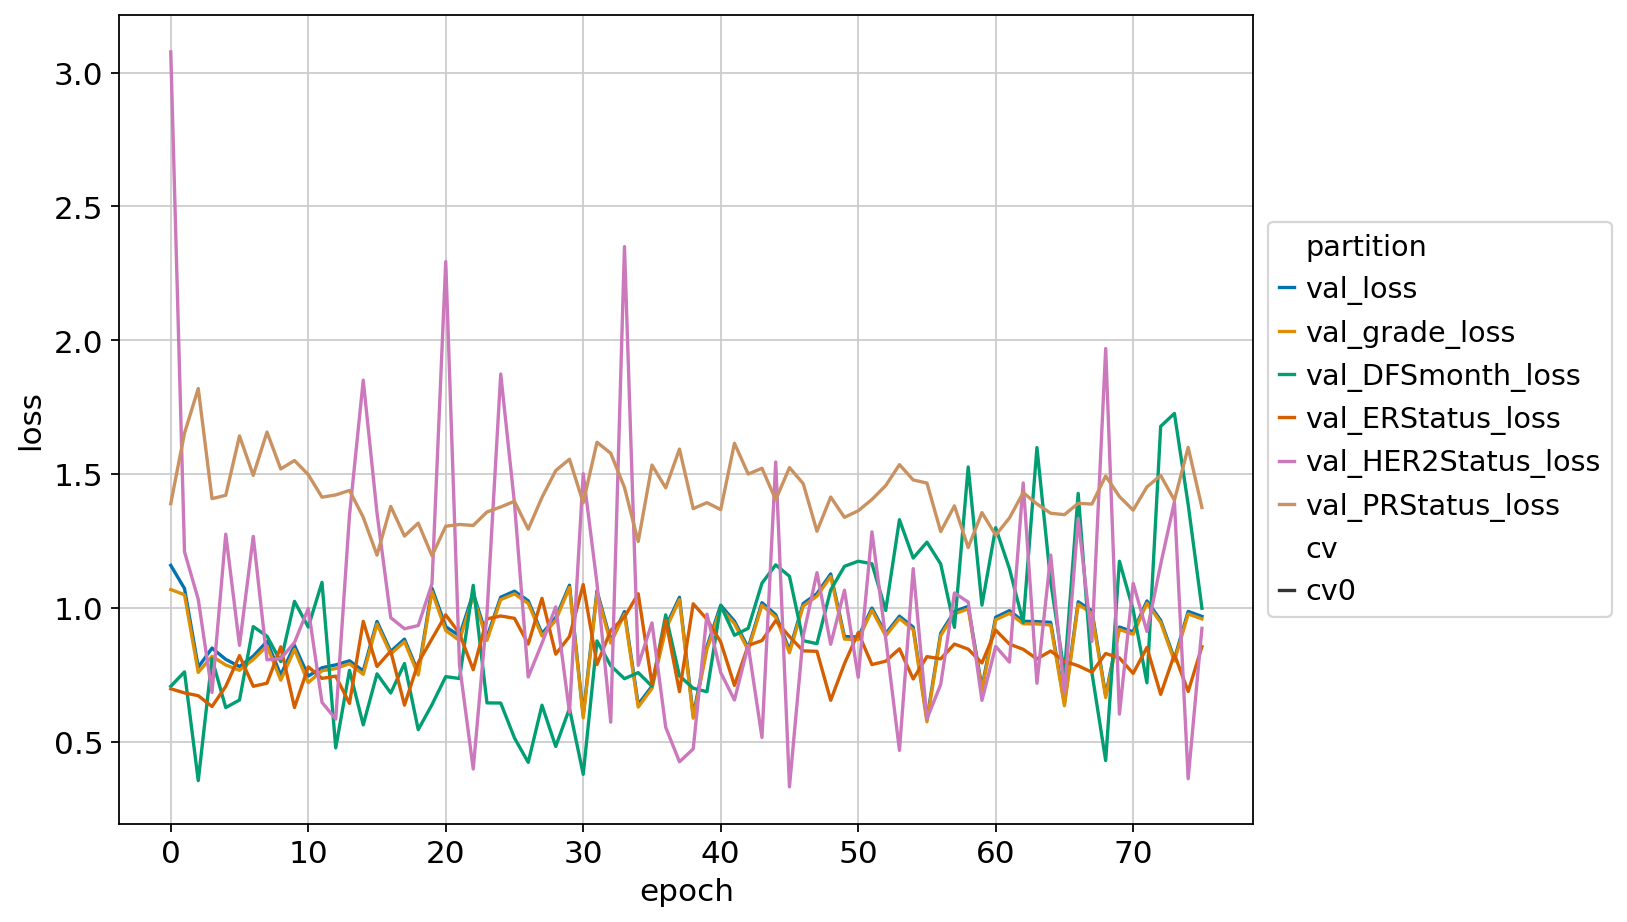

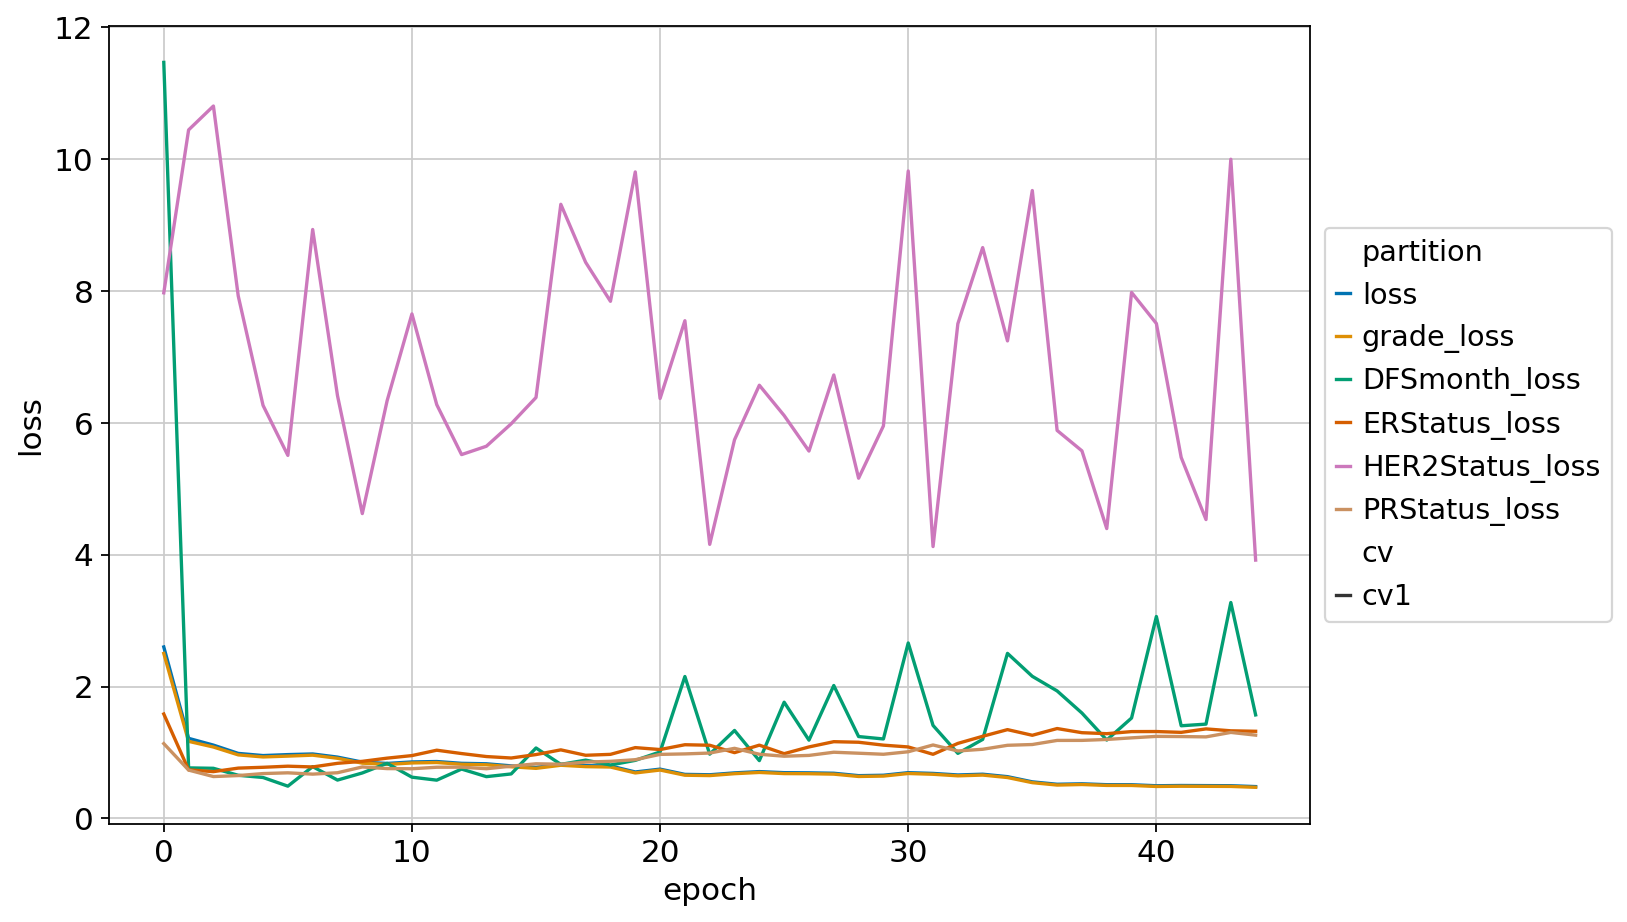

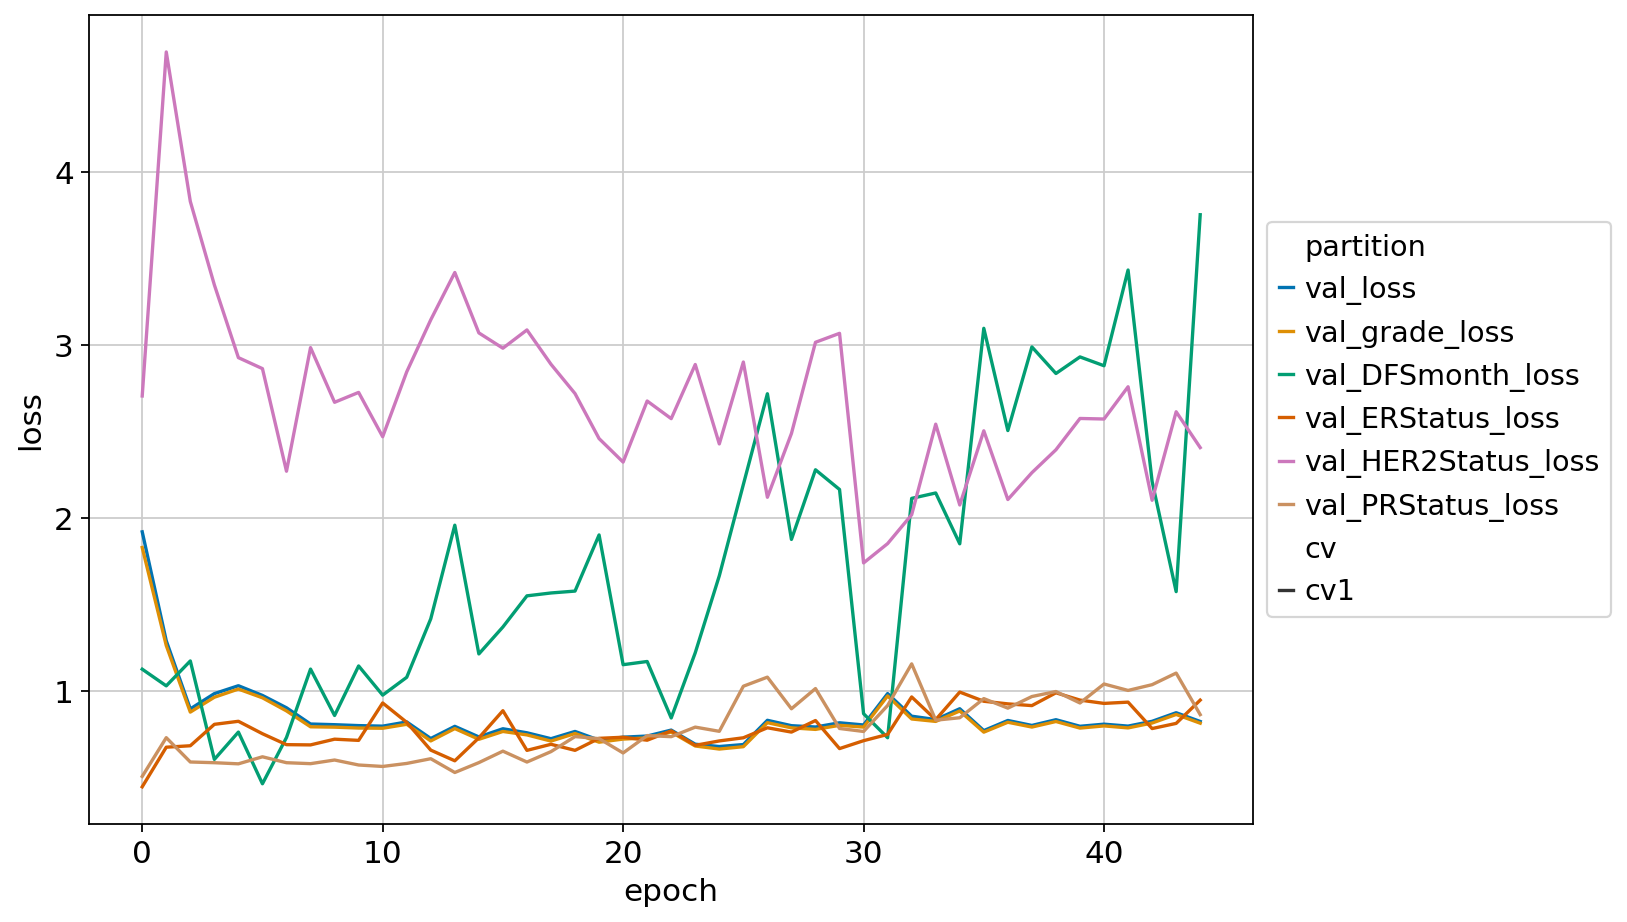

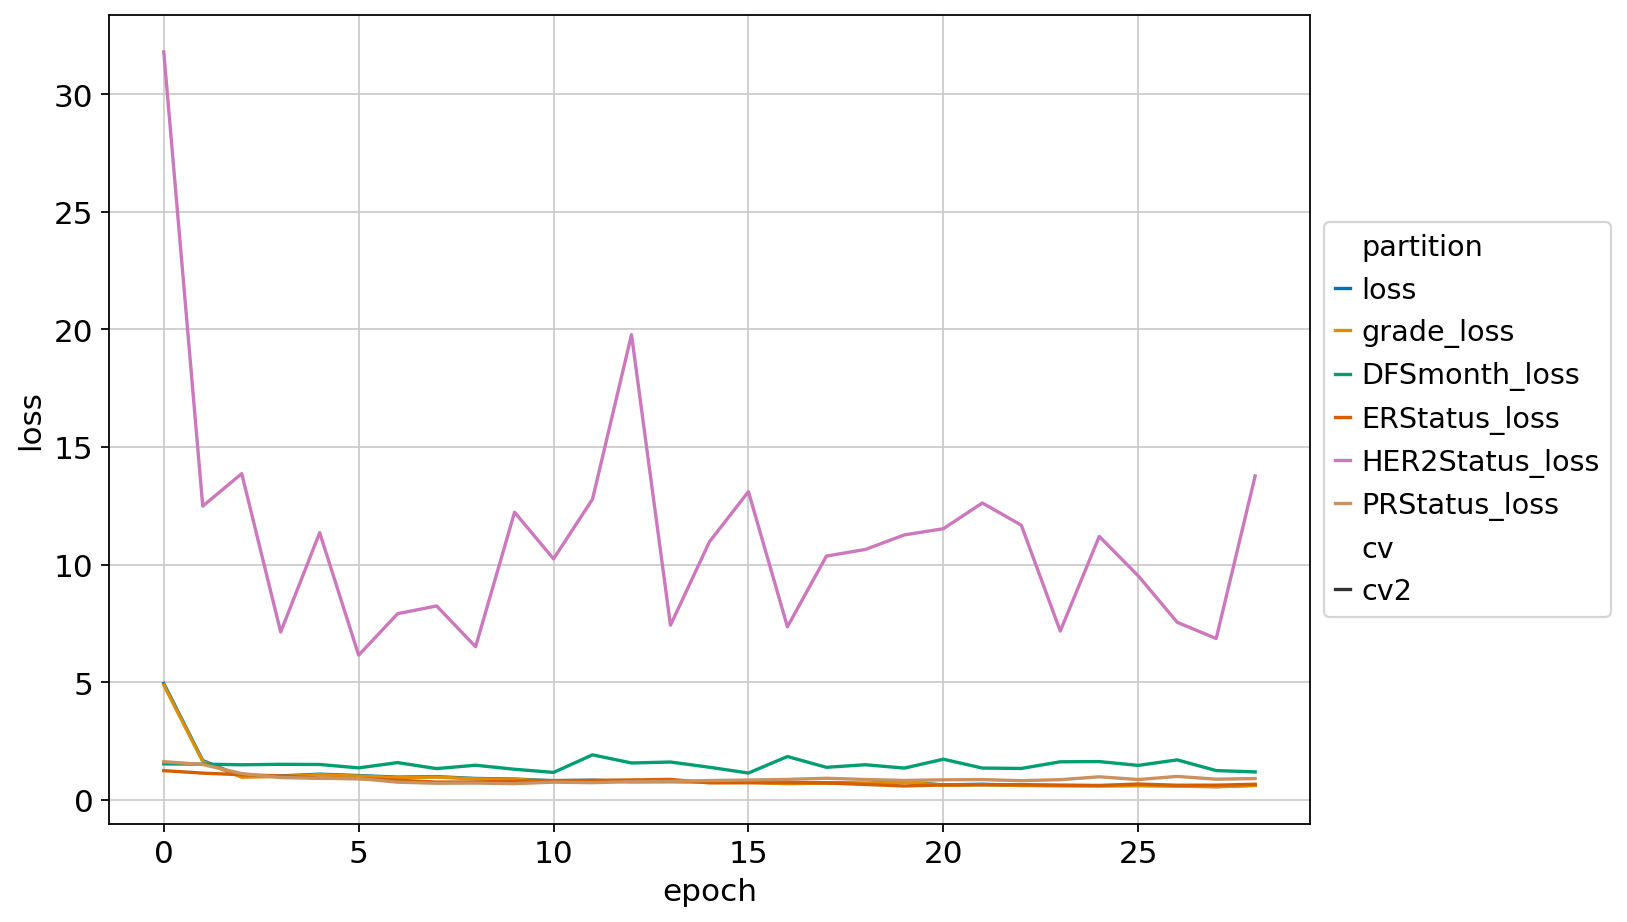

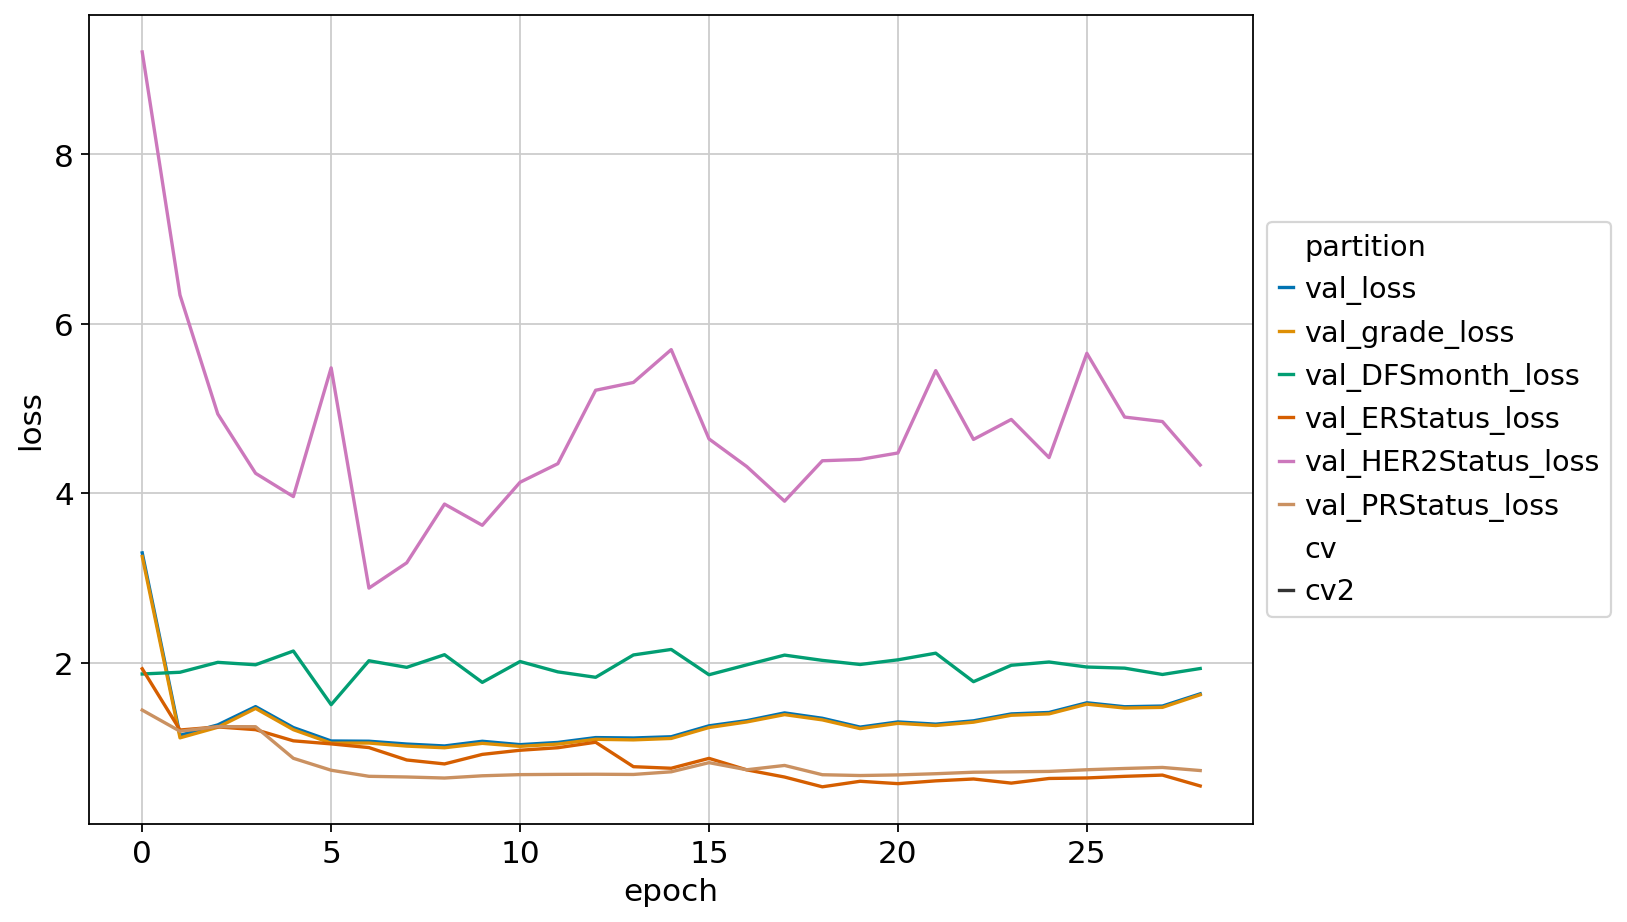

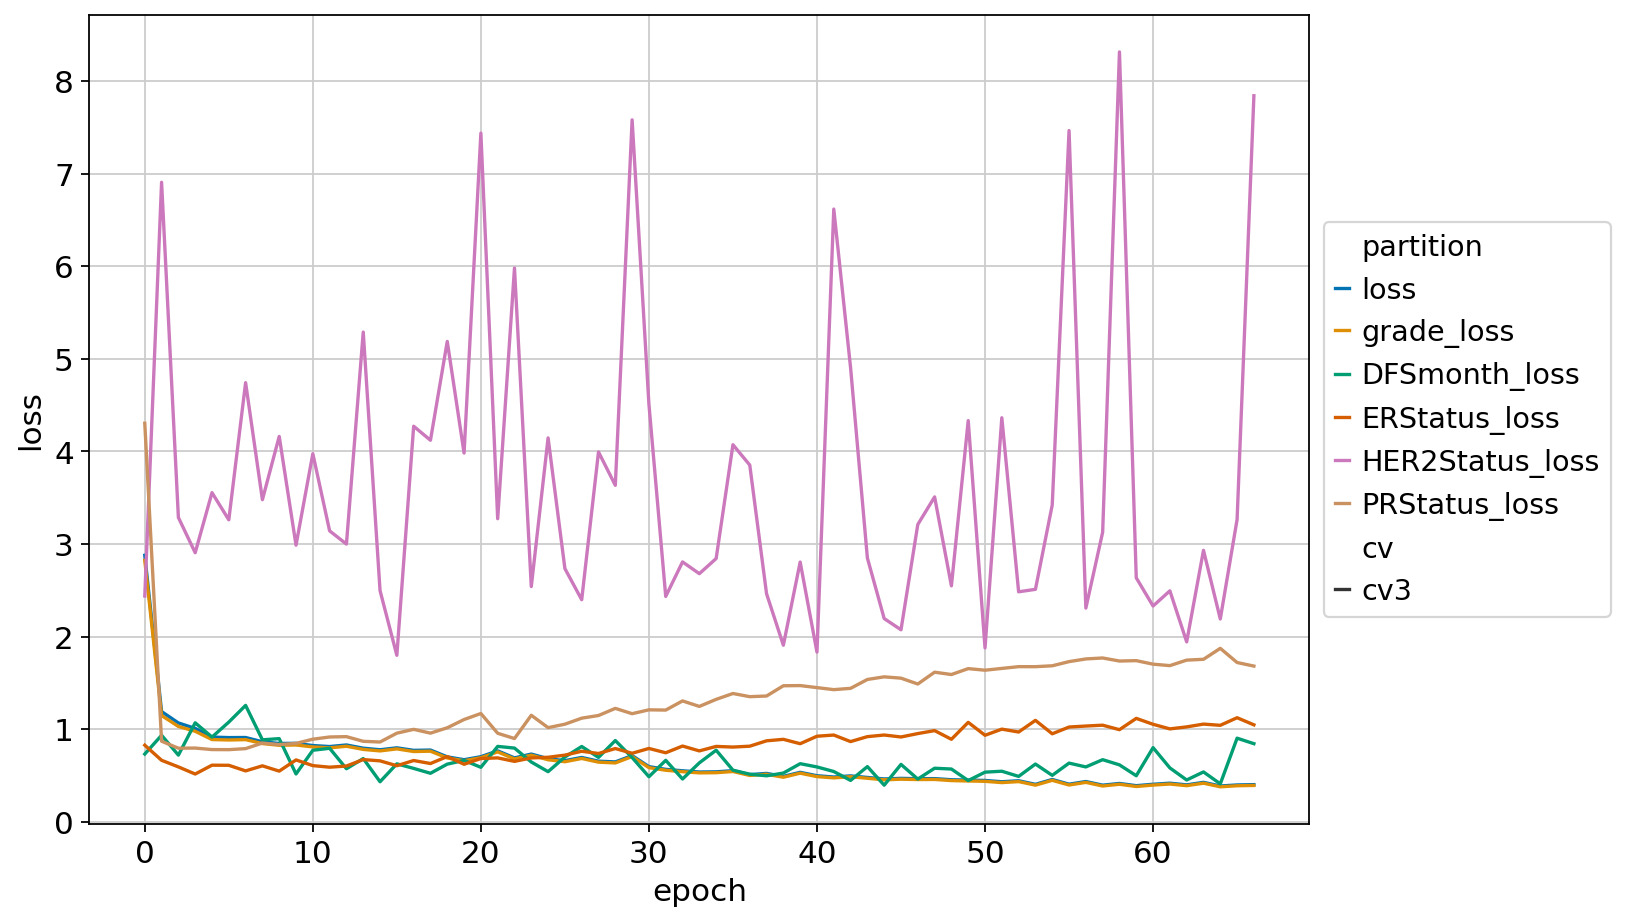

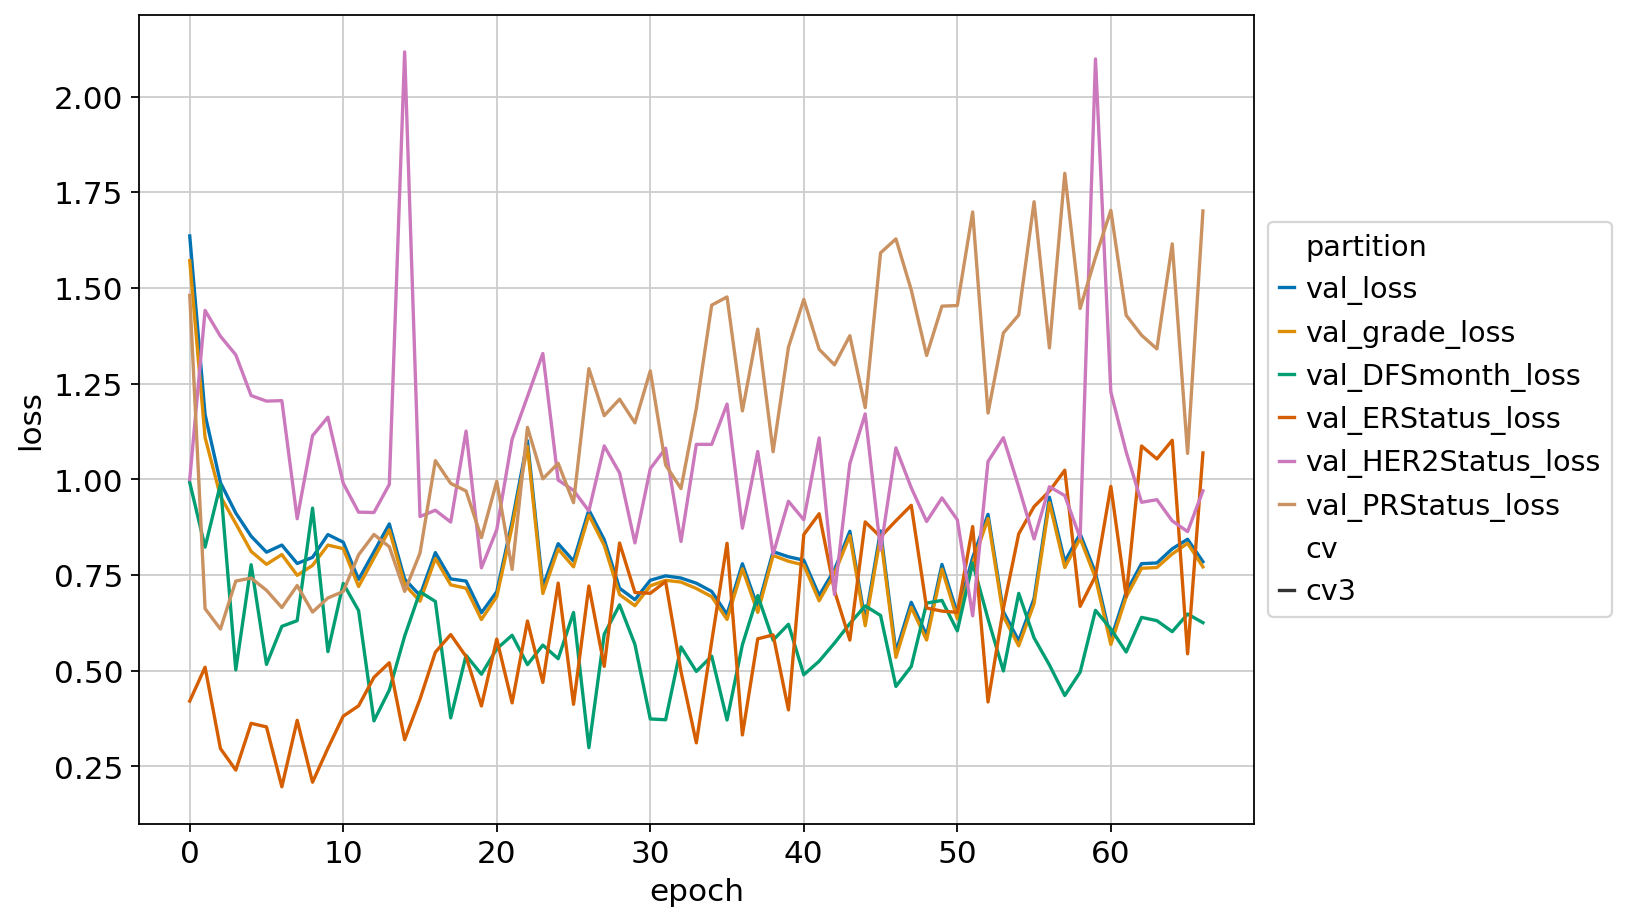

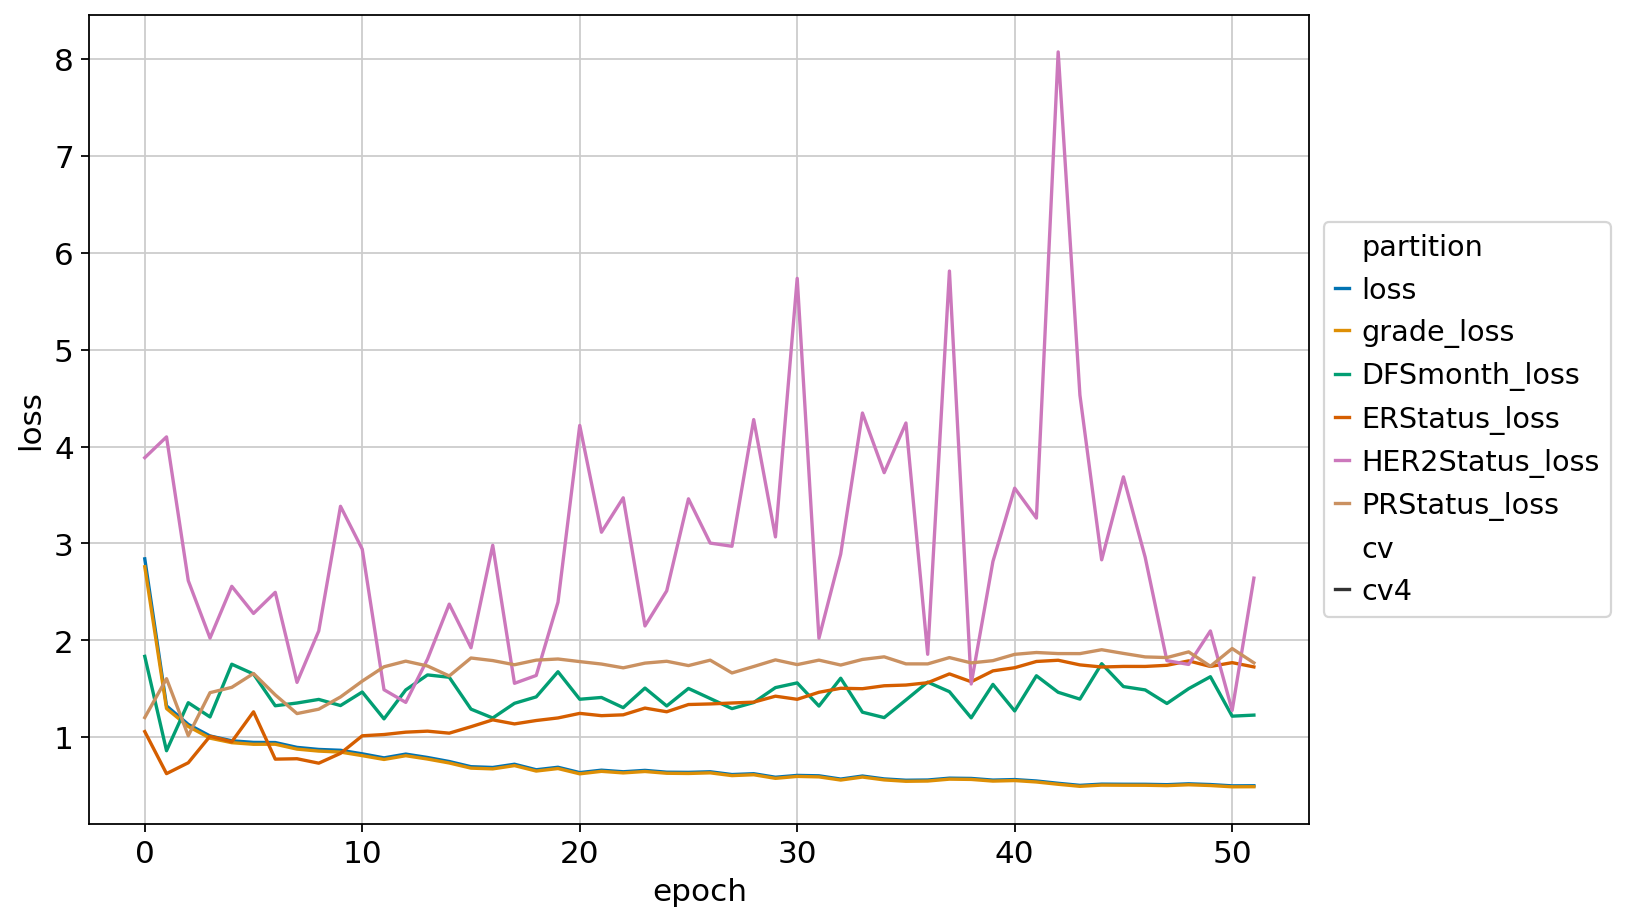

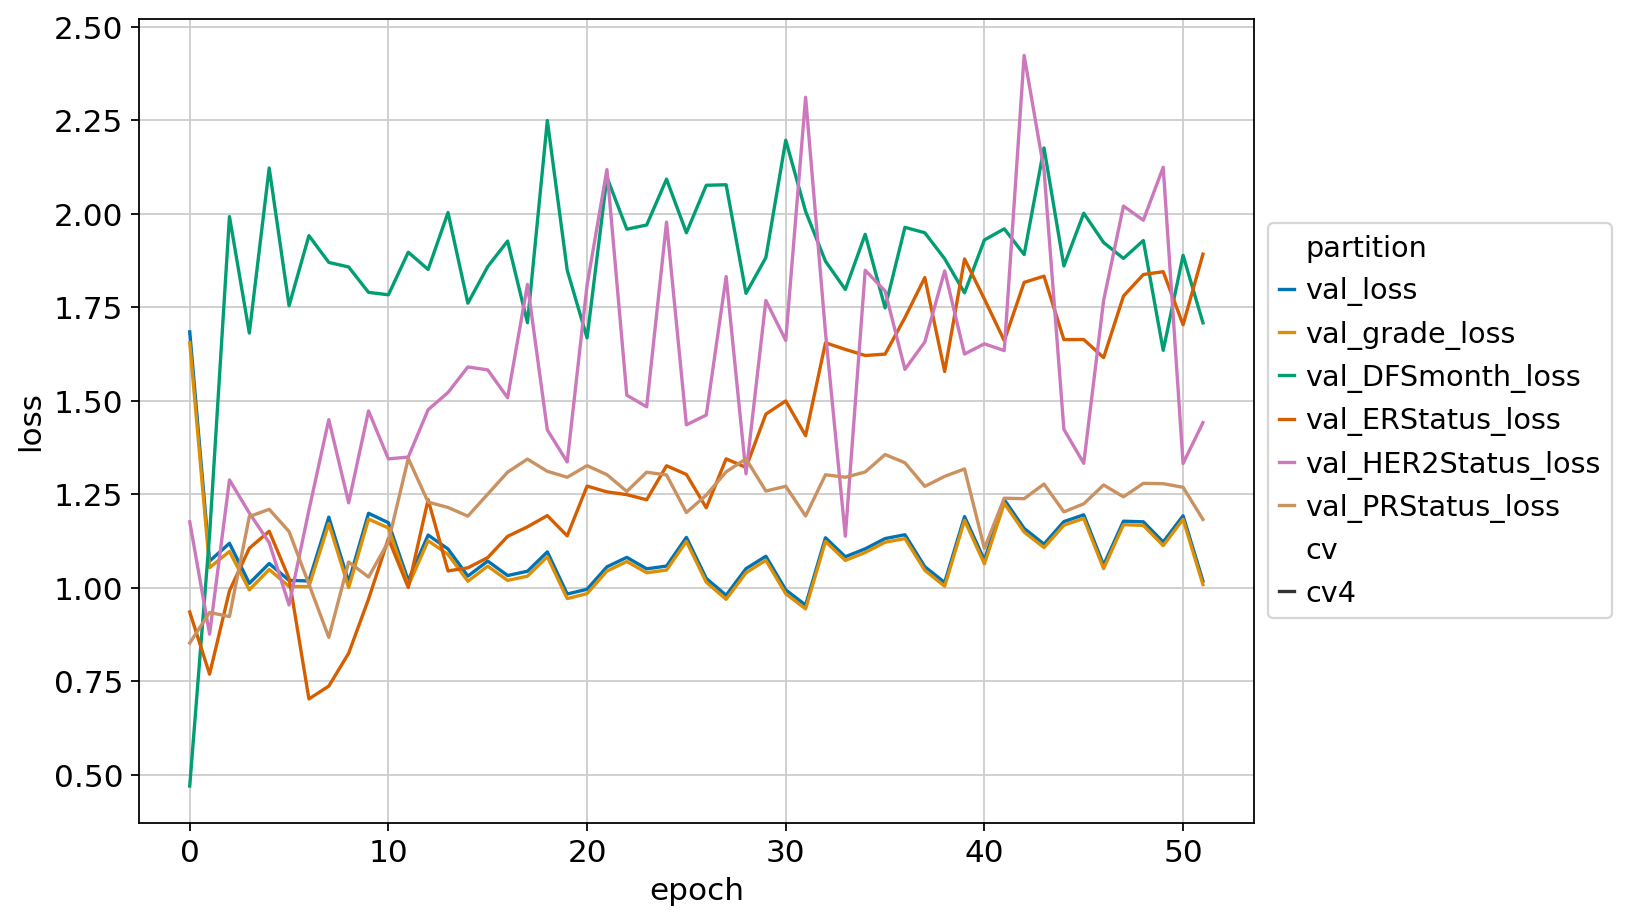

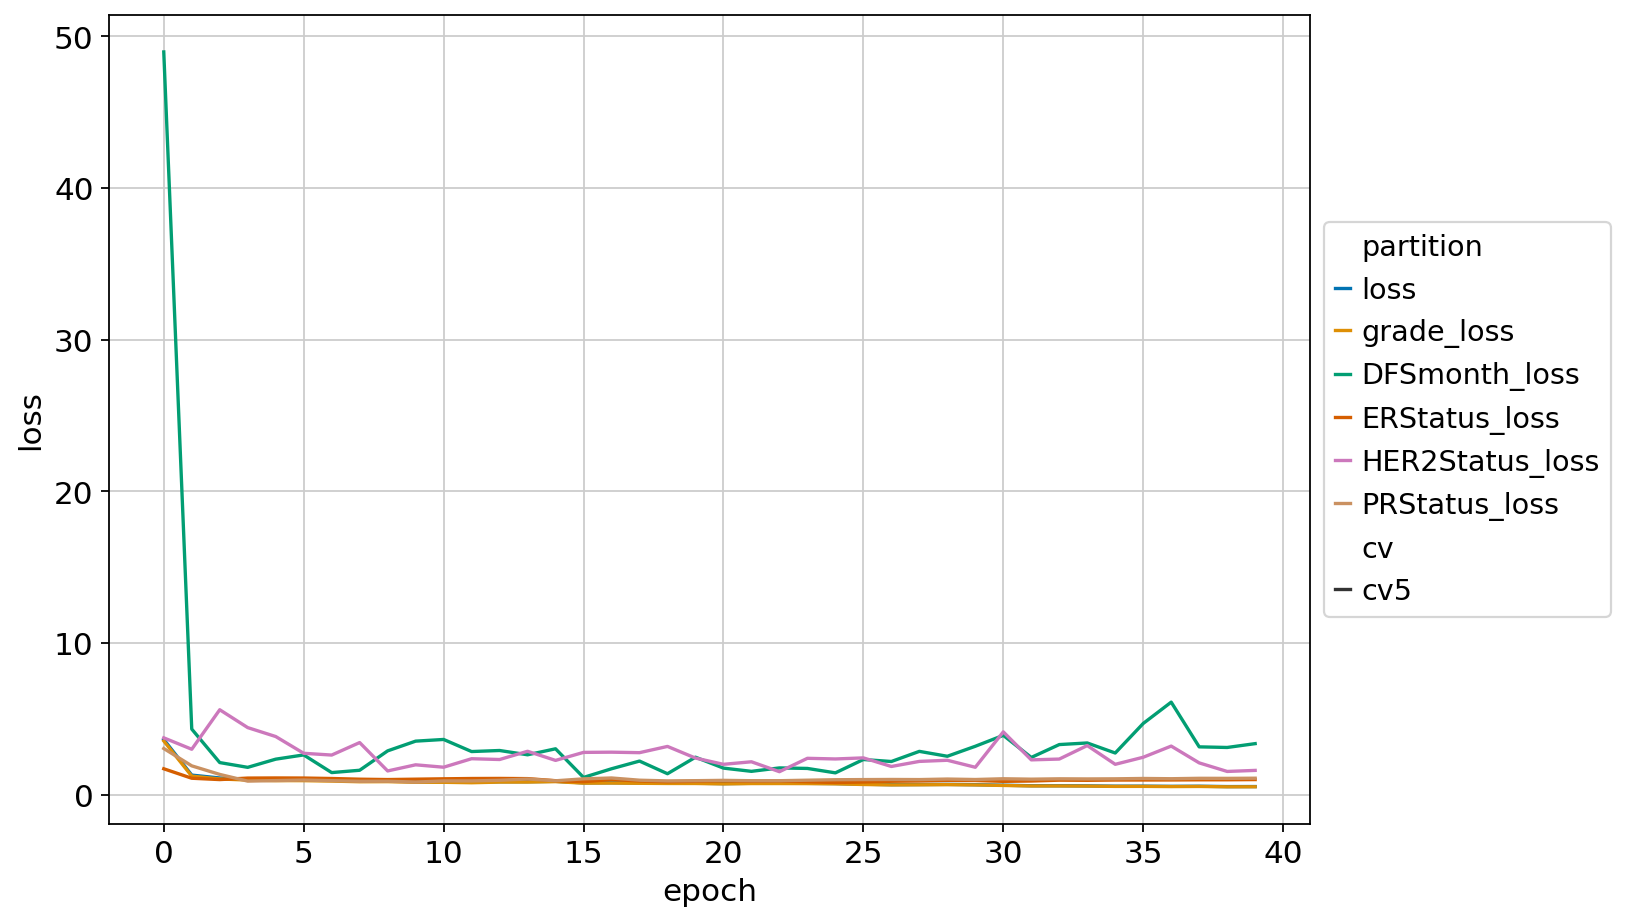

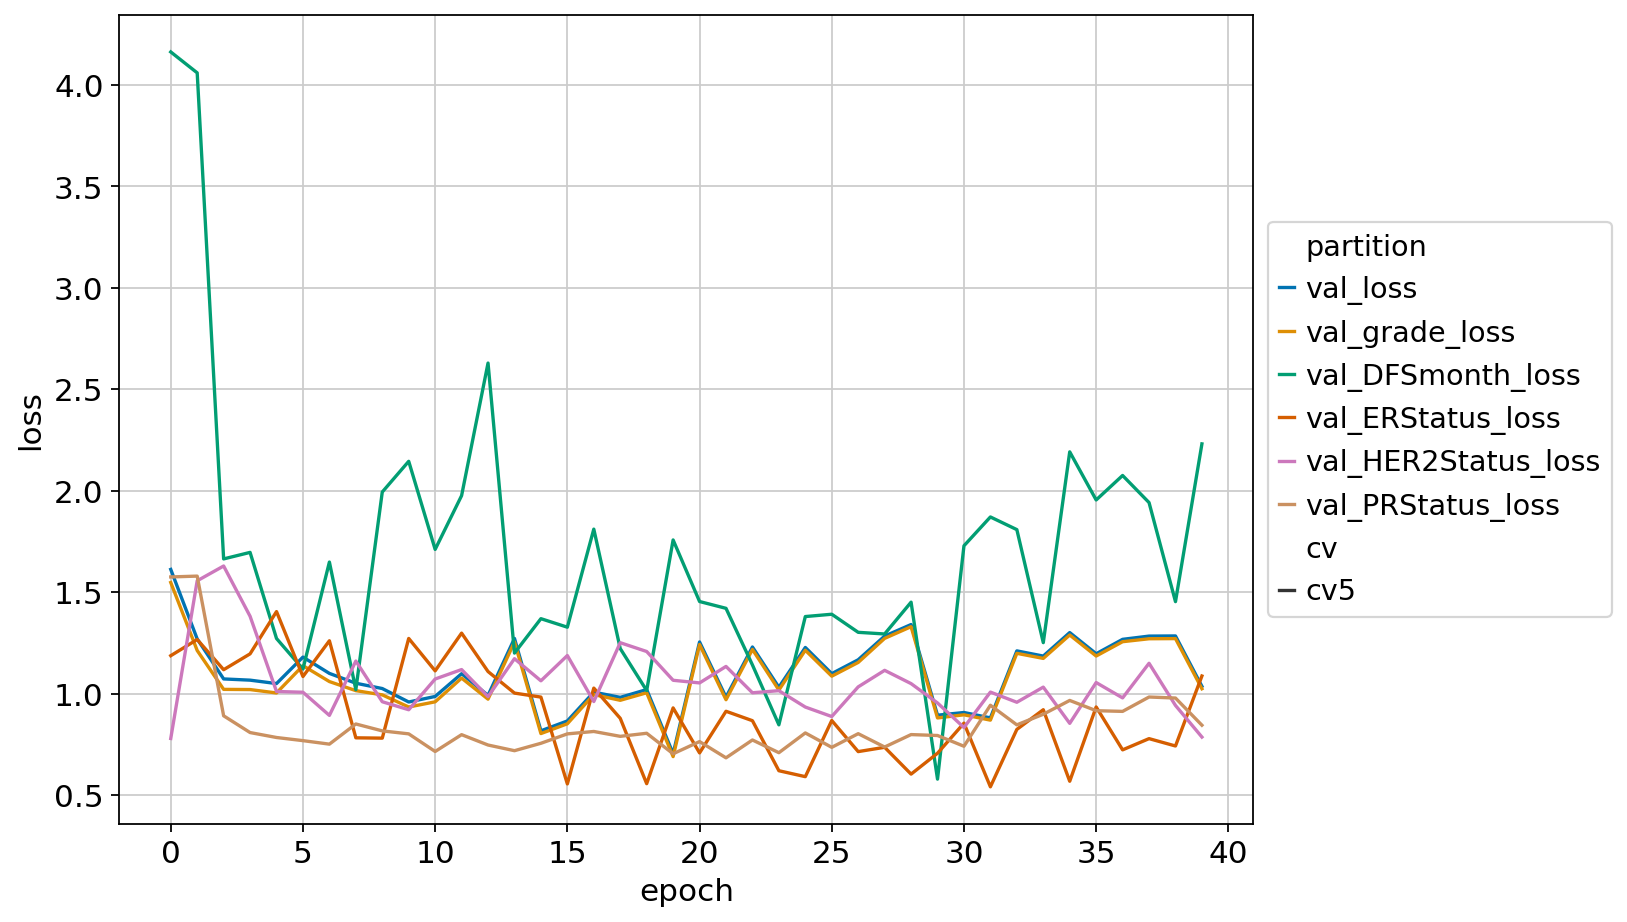

In [52]:
for cv in container_gcnss.cv_keys:
    # train history
    container_gcnss.plot_training_history(
        plot_metrics=['loss', 
                      f'{group_name}_loss', 
                      'DFSmonth_loss', 
                      'ERStatus_loss', 
                      'HER2Status_loss', 
                      'PRStatus_loss',
                     ],
        cv_keys=[cv],
    #     save=dir_figures+f"gcnss_analysis_mt_std_training_history_{cv}_{feature_space}_suppfig6c", 
    )
    
    # validation history
    container_gcnss.plot_training_history(
        plot_metrics=['val_loss', 
                      f'val_{group_name}_loss', 
                      'val_DFSmonth_loss', 
                      'val_ERStatus_loss', 
                      'val_HER2Status_loss', 
                      'val_PRStatus_loss',
                     ],
        cv_keys=[cv],
    #     save=dir_figures+f"gcnss_analysis_mt_std_validation_history_{cv}_{feature_space}_suppfig6c", 
    )

C. GCN SS interpretation analysis

In [10]:
interpreter = tissue.fits.InterpreterGraph(
    results_path=base_path_gcn + gs_id + "/results/", 
    cv=cv, 
    model_id=model_id, 
    model_class=model_class,
)
interpreter.load_model()

data_path="/lustre/groups/ml01/workspace/mayar.ali/tissue/data/zenodo/"
buffered_data_path="/lustre/groups/ml01/workspace/mayar.ali/tissue/data/zenodo/refactored/buffer"
interpreter.get_data_again(
    data_path=data_path,
    buffered_data_path=buffered_data_path,
    radius=20
)

2022-10-12 17:45:07.792965: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


/lustre/groups/ml01/workspace/mayar.ali/tissue/data/zenodo/refactored/buffer/buffered_data_20_fine.pickle
Loading data from buffer
Loaded 559 images with complete data from 350 patients over 1142488 cells with 34 cell features and 7 distinct celltypes.

Whole dataset: 559 images from 350 patients.
Test dataset: 50 images from 35 patients.
Training dataset: 450 images from 283 patients.
Validation dataset: 59 images from 32 patients.



In [55]:
# analysing accuracy and sample counts for varying node degrees

preds = np.argmax(container_gcnss.info[interpreter.cv]['predictions']['train'][group_name], axis=1)
true = np.argmax(container_gcnss.true_labels[interpreter.cv]['train'][group_name], axis=1)
acc = preds == true

idx = interpreter.img_keys_train
degrees = [np.mean(interpreter.data.img_celldata[image_key].obsp['adjacency_matrix_connectivities'].sum(axis=1))
            for image_key in idx]

nodes_sorted = np.sort(degrees)
order = np.argsort(degrees)
acc_sorted = np.array(acc)[order]
true_sorted = np.array(true)[order]

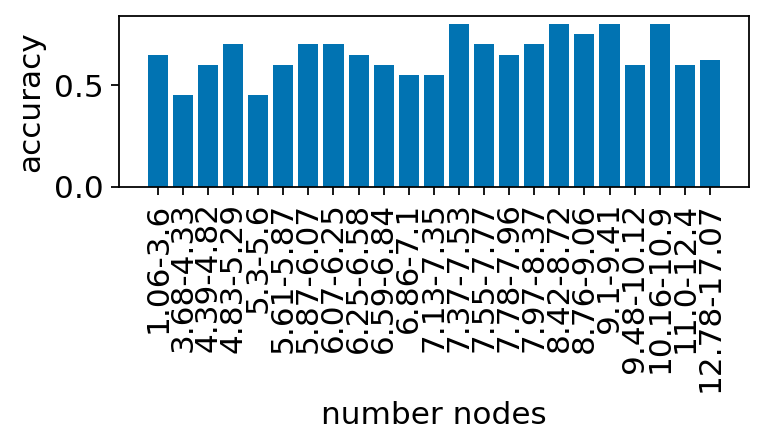

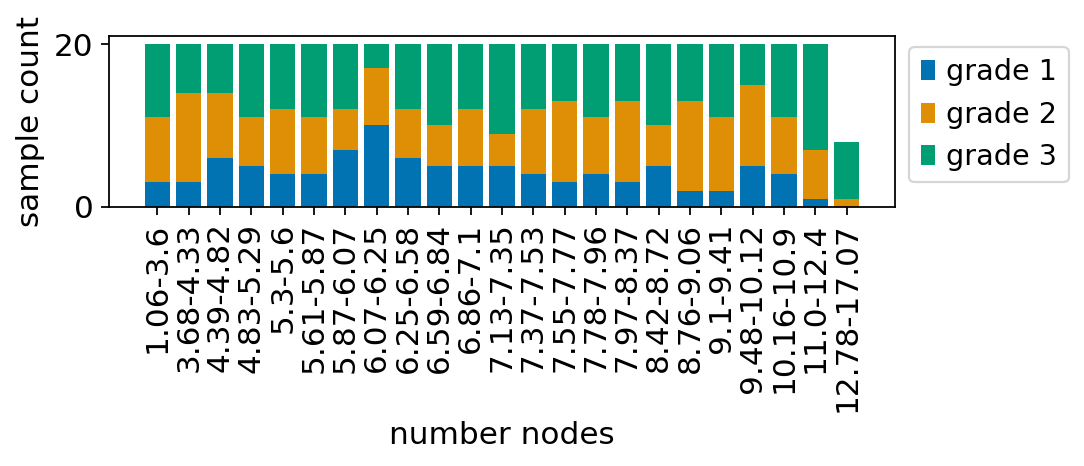

In [56]:
sns.set_palette("colorblind")

size = 20
accs = []
labels = []
plt.figure(figsize=(5,3))
a = []
b = []
c = []
for i in range(len(order)//size):
    accs.append(np.mean(acc_sorted[i*size:(i+1)*size]))
    labels.append(str(np.round(nodes_sorted[i*size], 2)) + '-' + str(np.round(nodes_sorted[(i+1)*size-1],2)))
    a.append(np.sum(true_sorted[i*size:(i+1)*size] == 0))
    b.append(np.sum(true_sorted[i*size:(i+1)*size] == 1))
    c.append(np.sum(true_sorted[i*size:(i+1)*size] == 2))
accs.append(np.mean(acc_sorted[len(order)//size*size:]))
labels.append(str(np.round(nodes_sorted[len(order)//size*size],2)) + '-' + str(np.round(nodes_sorted[-1], 2)))
a.append(np.sum(true_sorted[len(order)//size*size:] == 0))
b.append(np.sum(true_sorted[len(order)//size*size:] == 1))
c.append(np.sum(true_sorted[len(order)//size*size:] == 2))
plt.bar(height=accs, x=np.arange(len(accs)))
plt.xticks(np.arange(len(accs)), labels, rotation=90)
plt.xlabel('number nodes')
plt.ylabel('accuracy')
plt.tight_layout()
plt.grid(False)
# plt.savefig(dir_figures + f'gcnss_interpretation_node_degree_accuracy_{feature_space}_supfig3b.pdf')
plt.show()

    
plt.figure(figsize=(7,3))
plt.bar(x=np.arange(len(accs)), height=a, label='grade 1')
plt.bar(x=np.arange(len(accs)), height=b, bottom=a, label='grade 2')
plt.bar(x=np.arange(len(accs)), height=c, bottom=np.array(a) + np.array(b), label='grade 3')
plt.legend(bbox_to_anchor=(1.0, 1.02))
plt.xlabel('number nodes')
plt.ylabel('sample count')
plt.xticks(np.arange(len(accs)), labels, rotation=90)
plt.tight_layout()
plt.grid(False)
# plt.savefig(dir_figures + f'gcnss_interpretation_node_degree_sample_count_{feature_space}_supfig3c.pdf')
plt.show()


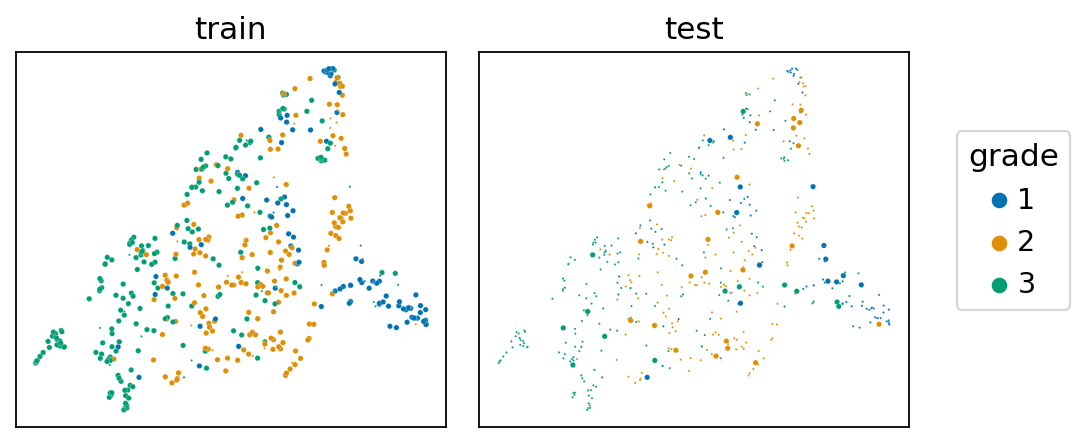

In [13]:
# plotting UMAP of graph embeddings
embedding, hue = interpreter.plot_umap_graphs(
    label=group_name,
    data_key=data_key,
    return_embeddings=True,
    save=dir_figures + f'gcnss_interpretation_umap_graph_{feature_space}_fig3a.pdf'
)

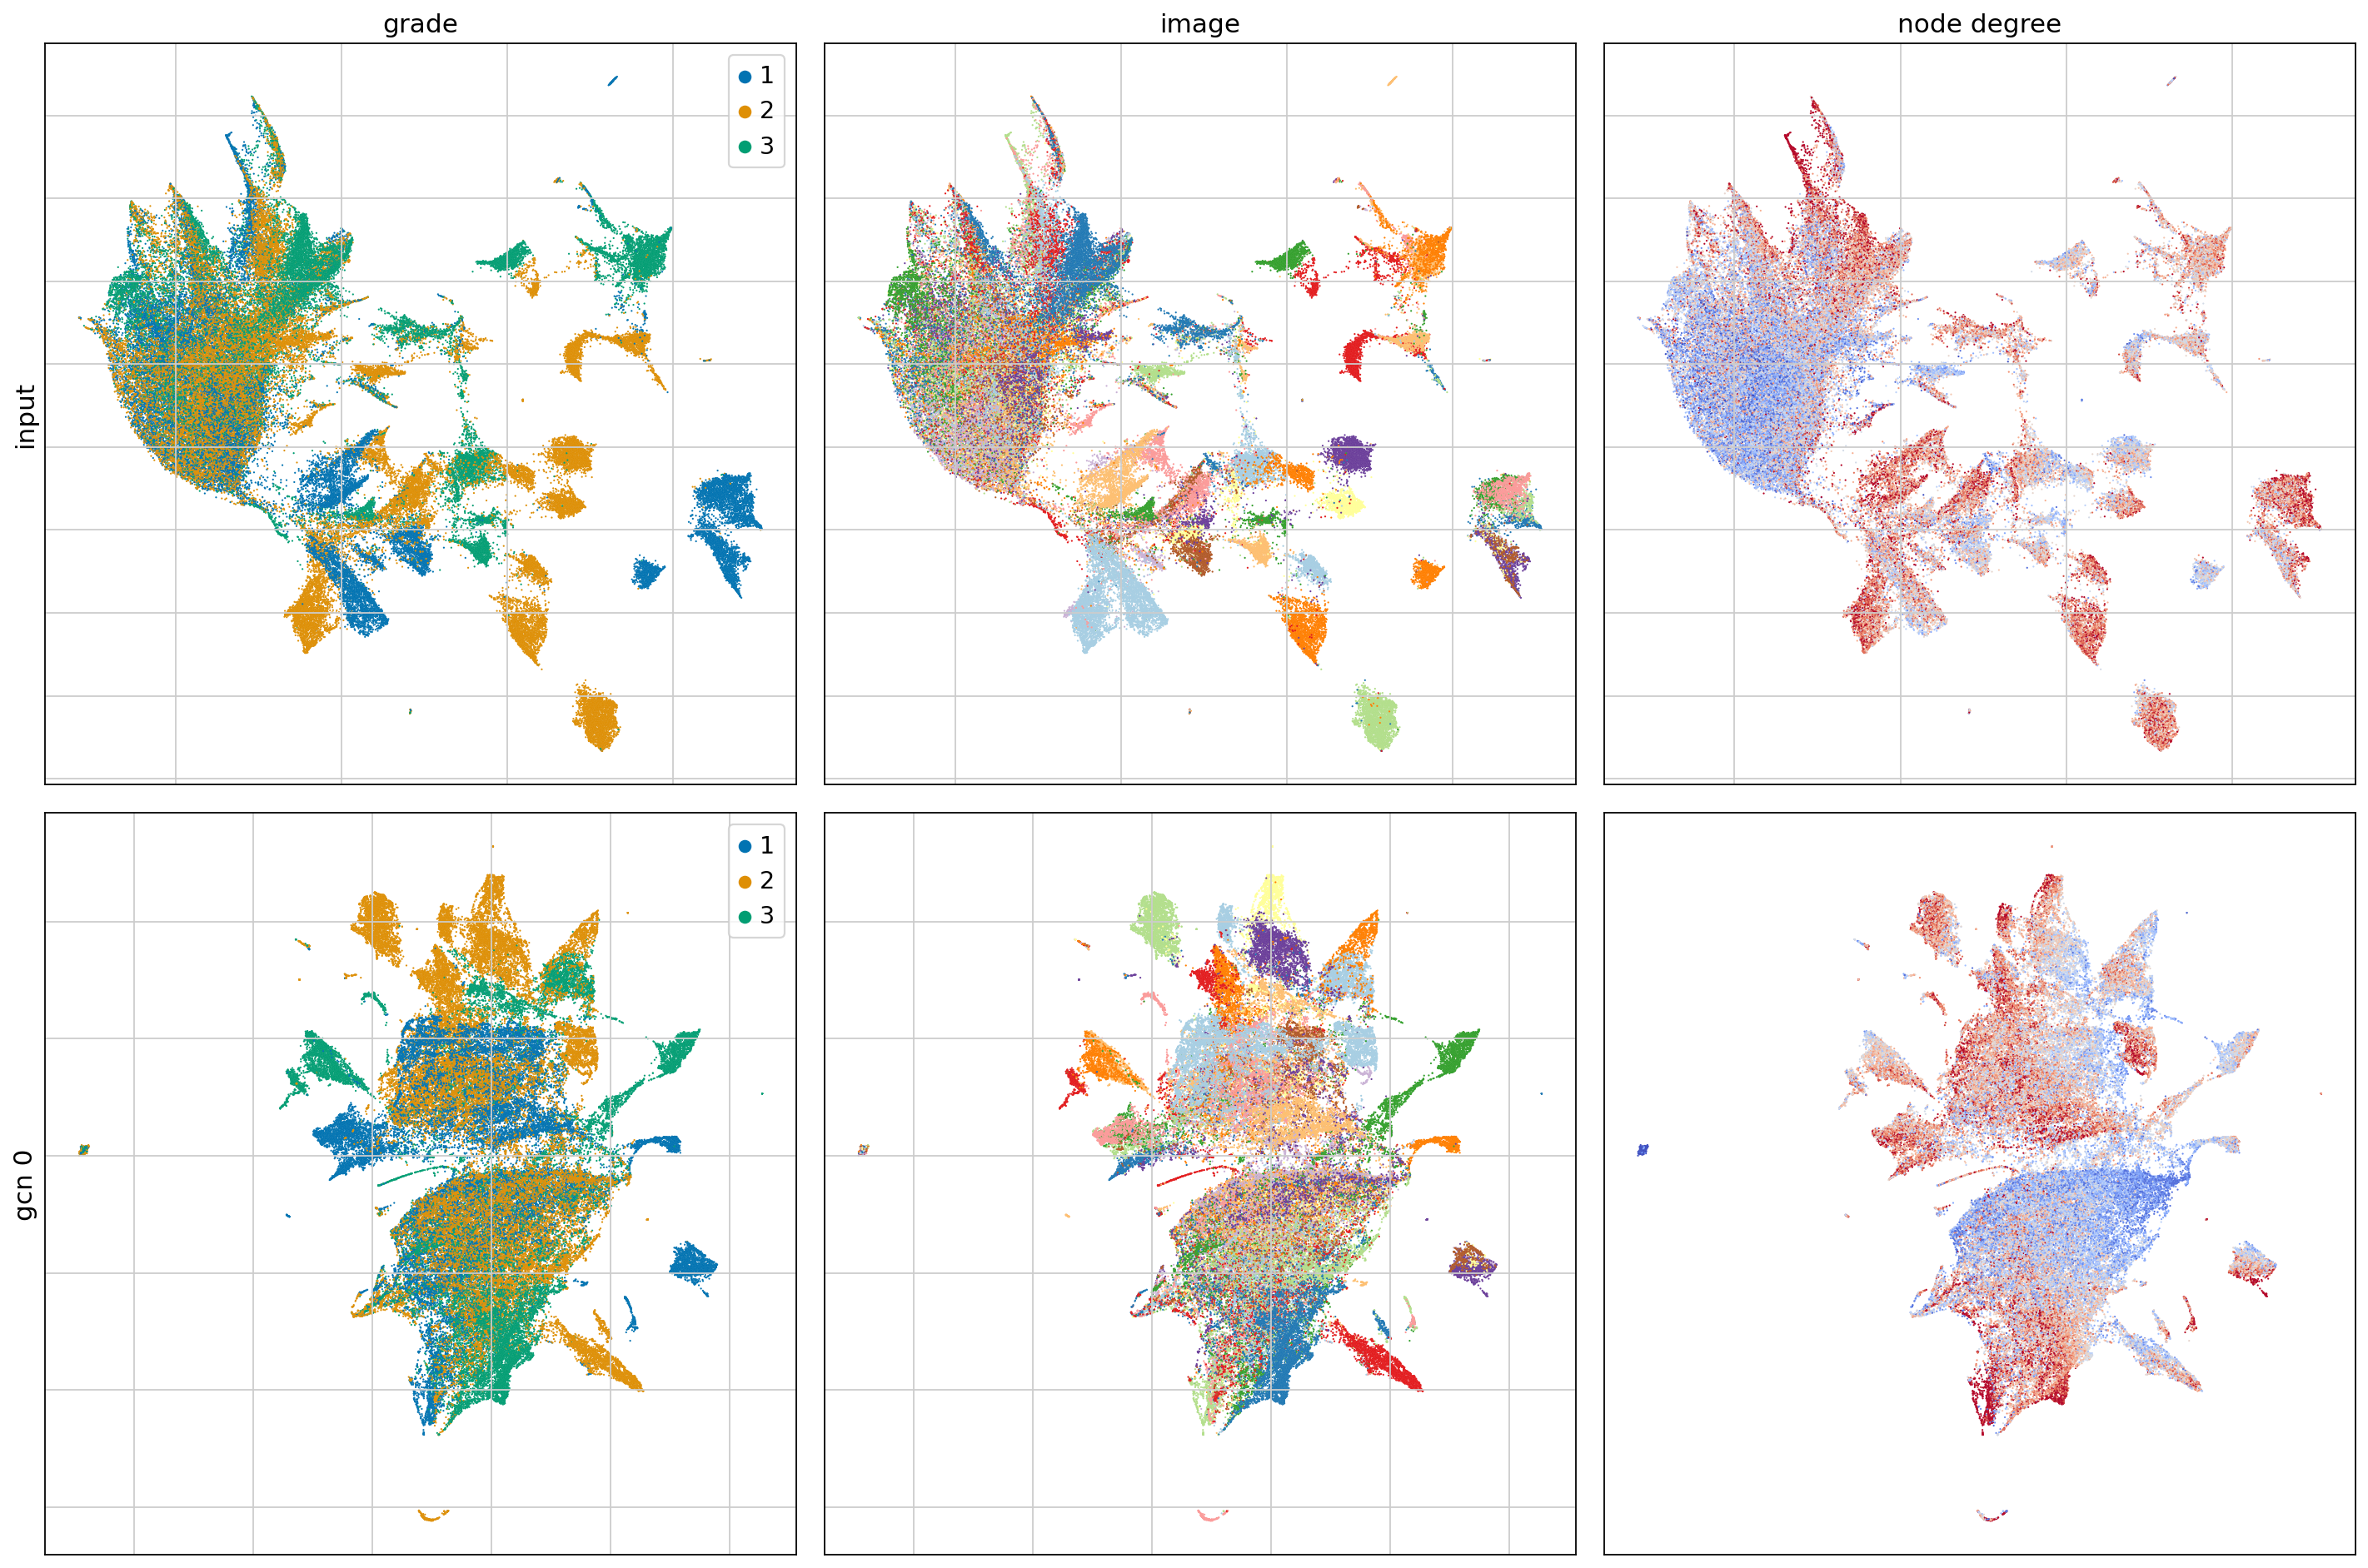

In [35]:
# plotting UMAP of node embeddings for the different gcn layers
interpreter.plot_umap_nodes(
    interpreter.img_keys_test,
    plot_types = [group_name, 'images', 'degree'],
    layer_names=[
        'input',
        'Layer_gcn_0',
    ],
    panel_width=6.0,
    panel_height=6.0,
    data_key=data_key,
    # plt.savefig(dir_figures + f'gcnss_interpretation_umap_nodes_{feature_space}.pdf')
)

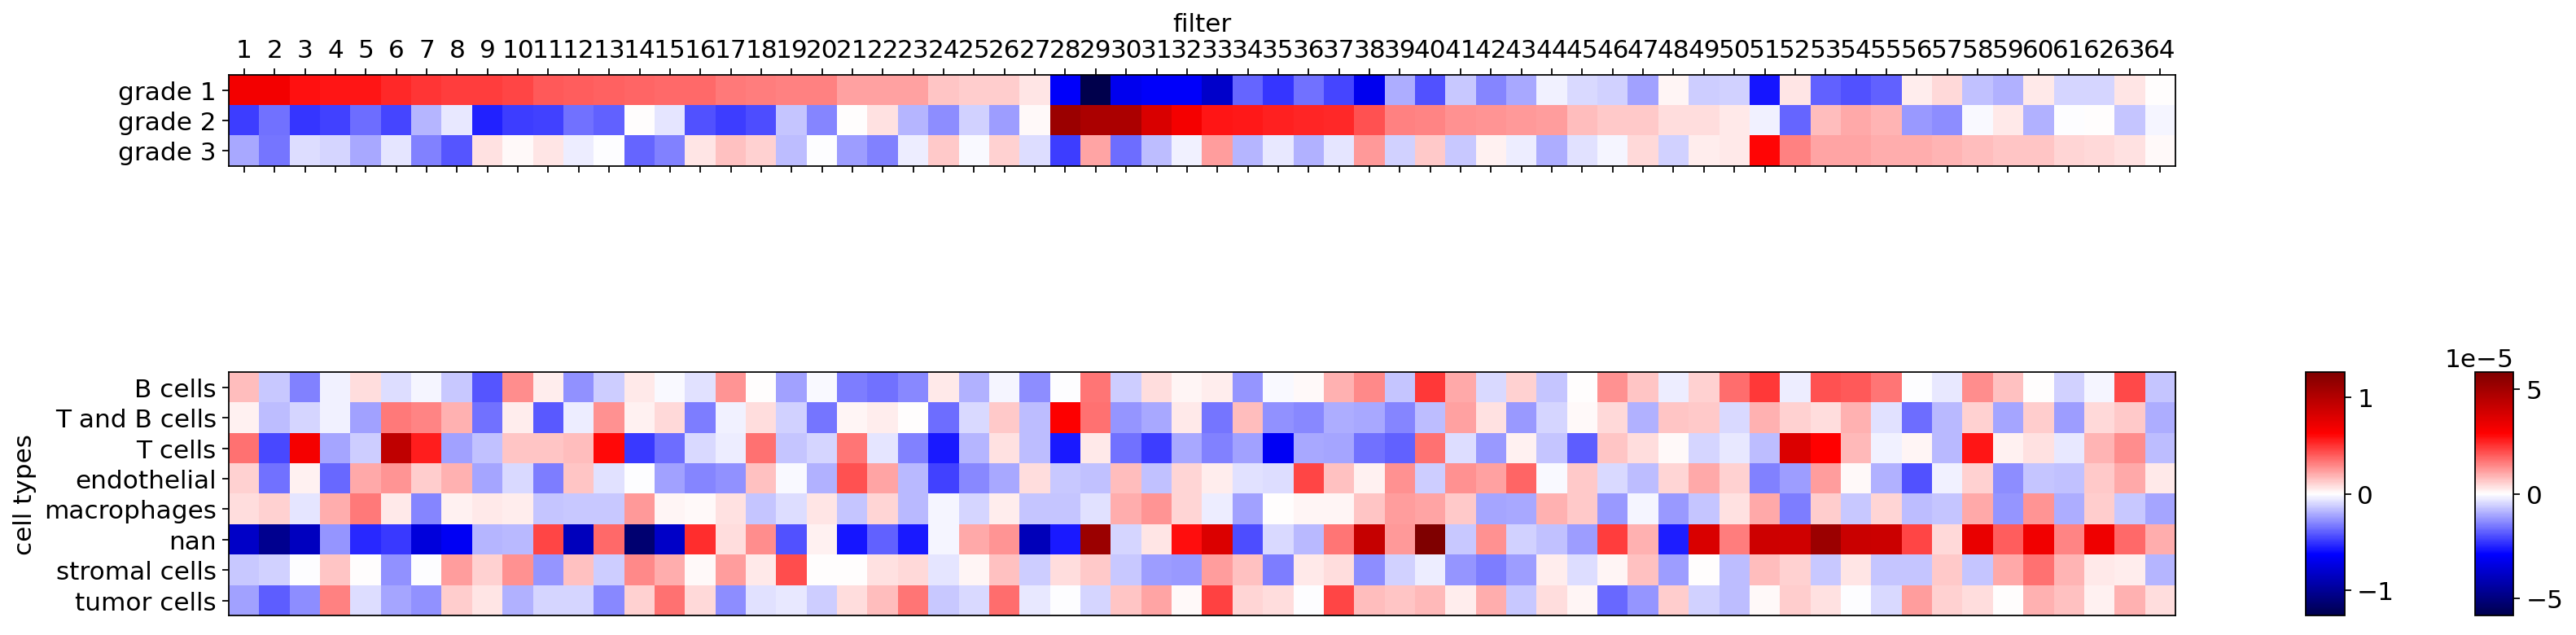

In [49]:
# plotting weight filters for first layer of gcn sorted by groups
interpreter.plot_weight_matrix(
    layer_name='Layer_gcn_0', 
    target_label='grade',
    panel_width=20,
    panel_height=20,
    data_key=data_key,
    # plt.savefig(dir_figures + f'gcnss_interpretation_filters_weights_{feature_space}_fig3a.pdf')
)